### Basically lets streamline http://localhost:8888/notebooks/Feb2019/20619/2-13-19%20FIMO-based%20representation%20graph%20.ipynb  and make it ready to be scaled for all motif combos at once

In [1]:
import numpy as np
import pandas as pd

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.gridspec as gridspec

import datetime
from scipy.stats import fisher_exact


In [2]:
finname = '20619_FIMOtable_clusters.txt'
print(datetime.datetime.now())
DF = pd.read_table(finname, dtype=int)
print(datetime.datetime.now())


2019-02-14 18:23:55.812206
2019-02-14 18:25:55.246009


In [3]:
Comp_colors = ['#FFE500', '#FE8102', '#FF0000', '#07AF00', '#4C7D14', '#414613', '#05C1D9', '#0467FD', '#009588', '#BB2DD4', '#7A00FF', '#4A6876', '#08245B', '#B9461D', '#692108', '#C3C3C3']
neworder = np.array([16,10,7,11,2,12,1,8,4,15,14,5,9,6,3,13]).astype(int) - 1
Comp_colors = np.array(Comp_colors)[neworder]

In [4]:
WSO = np.array([7,5,15,9,12,14,3,8,13,2,4,6,16,11,10,1]).astype(int) - 1
strings_of_labels = ['tissue-invariant', 'fibroblast1', 'embryonic', 'fibroblast2', 'lymphoid', 'epithelial / kidney (cancer)', 'placenta','neuronal','cardiac','fetal kidney','fetal lung','musculoskeletal',\
                     'digestive','vascular / endothelial','HSC / myeloid / erythroid', 'epithelial']
strings_of_labels = np.array(strings_of_labels)

In [5]:
Mixture = np.load('2018-06-08NC16_NNDSVD_Mixture.npy')
NormedMixture = Mixture/np.sum(Mixture,axis=0)
maxcolor = np.argsort(NormedMixture, axis=0)[-1]
maxcolor_vals = np.sort(NormedMixture, axis=0)[-1]
secondmaxcolor = np.argsort(NormedMixture, axis=0)[-2]
secondmaxcolor_vals = np.sort(NormedMixture, axis=0)[-2]

In [6]:
motif1 = 'c14.MEF2A'
motif2 = 'c65-NEURO/OLIG'

In [16]:
motif_pair_cut = (DF[motif1].values > 0 ) * (DF[motif2].values > 0 )

In [82]:
G1cut = (secondmaxcolor_vals<=0.25) * (maxcolor_vals>0.5) 
G2cut = (secondmaxcolor_vals>0.25) * (maxcolor_vals>0.5) 
G3cut = (secondmaxcolor_vals>0.25) * (maxcolor_vals<=0.5) 
G4cut = (secondmaxcolor_vals<=0.25) * (maxcolor_vals<=0.5) 


### lets make a function to define expected matrices

In [26]:
# returns expectation value matrix that can be sent to big_grid_plot when in OOE mode.

def return_expected_matrix(Gcut, rownormed=False):
    maxcolor_bincount = np.bincount(maxcolor[Gcut], minlength=16)
    seccolor_bincount = np.bincount(secondmaxcolor[Gcut], minlength=16)

    bincount_matrix_cutoff = []
    for comp in range(16):
        bincut_row = []
        maincut = maxcolor[Gcut] == comp
        for j in range(16):
            seccut = (secondmaxcolor[Gcut] == j) *  (secondmaxcolor_vals[Gcut]>0)
            if comp == j:
                seccut = secondmaxcolor_vals[Gcut]==0
            N_in_square_cut = maincut * seccut
            N_in_square = np.sum(N_in_square_cut)
            bincut_row.append(N_in_square)
        bincount_matrix_cutoff.append(bincut_row)
    bincount_matrix_cutoff = np.array(bincount_matrix_cutoff)
    if rownormed:
        bincount_matrix_cutoff_rownormed = (bincount_matrix_cutoff.T / np.sum(bincount_matrix_cutoff, axis=1)).T
        bincount_matrix_cutoff_rownormedPD = pd.DataFrame(bincount_matrix_cutoff_rownormed, columns=strings_of_labels)
        bincount_matrix_cutoff_rownormedPD['domcomp'] = strings_of_labels
        bincount_matrix_cutoff_rownormedPD.set_index('domcomp', inplace=True)
    
    bincount_matrix_cutoffPD = pd.DataFrame(bincount_matrix_cutoff, columns=strings_of_labels)
    bincount_matrix_cutoffPD['domcomp'] = strings_of_labels
    bincount_matrix_cutoffPD.set_index('domcomp', inplace=True)

        #return both  counts and row-normed version
    if rownormed:
        return [bincount_matrix_cutoffPD, bincount_matrix_cutoff_rownormedPD]

    return bincount_matrix_cutoffPD

In [152]:

'{:6.2f}'.format(3.141592653589793)

'  3.14'

In [174]:
'{:6.2f}'.format(3.141592653589793).strip(' ')

'3.14'

In [167]:
def big_grid_plot(Gcut, plt_title = '', do_row_normalized_shading=True, do_extra_bargraphs=True, logOOEmode=False, adjust_significance=False, ExpectedMatrix = [], pmatrix = [] ):
    maxcolor_bincount = np.bincount(maxcolor[Gcut], minlength=16)
    seccolor_bincount = np.bincount(secondmaxcolor[Gcut], minlength=16)

    # possibly need to revise this - by default, the expectation value is just all sites
    maxcolor_bincount_OOE = np.bincount(maxcolor[Gcut], minlength=16) /  np.bincount(maxcolor, minlength=16) * (len(maxcolor) / len(maxcolor[Gcut]))

    seccolor_bincount_OOE =  np.bincount(secondmaxcolor[Gcut*(secondmaxcolor_vals>0)], minlength=16) /  np.bincount(secondmaxcolor[secondmaxcolor_vals>0], minlength=16) * (len(secondmaxcolor[secondmaxcolor_vals>0]) / len(secondmaxcolor[Gcut* (secondmaxcolor_vals>0)]))
    
    
    if do_row_normalized_shading:
        [bincount_matrix_cutoff_G_PD, bincount_matrix_cutoff_G_rownormedPD] = return_expected_matrix(Gcut, True)
    else:
        bincount_matrix_cutoff_G_PD = return_expected_matrix(Gcut)
    

    
    gs1 = gridspec.GridSpec(5,5)
    fig = plt.figure(figsize = (24,22))
    plt.clf()
    f = plt.subplot2grid((5,5), (0,1), colspan=3, rowspan=3)
    
    
    if (do_row_normalized_shading):
        kox= sns.heatmap(bincount_matrix_cutoff_G_rownormedPD[strings_of_labels[WSO]].reindex(strings_of_labels[WSO]), annot=bincount_matrix_cutoff_G_PD[strings_of_labels[WSO]].reindex(strings_of_labels[WSO]).values.astype(int), cmap='binary', vmax=0.5, fmt='d', cbar_kws={'fraction':0.046, 'pad':0.04} )
        kox.collections[0].colorbar.set_label('secondary fraction', fontsize=25)
    elif logOOEmode:
        if len(ExpectedMatrix) < 1: 
            print('error, must pass return matrix')
            plt.close()
            return
        group_rat = bincount_matrix_cutoff_G_PD / ExpectedMatrix
        group_fix = ExpectedMatrix.sum().sum() / bincount_matrix_cutoff_G_PD.sum().sum()

        thing_to_heatmap = np.log10(group_fix*group_rat[strings_of_labels[WSO]].reindex(strings_of_labels[WSO])+1e-5) / np.log10(2) #using log2 
        
        if (adjust_significance):            
            temp_annotations = thing_to_heatmap.values
            annotations = []
            
            for i in range(len(temp_annotations)):
                irow = []
                for j in range(len(temp_annotations)):
                    cellvalue = '{:6.2f}'.format(temp_annotations[i][j]).strip(' ')
                    if pmatrix[i][j]:
                        irow.append(cellvalue+'*')
                    else:
                        irow.append(cellvalue)
                annotations.append(irow)
            annotations = np.array(annotations)
            
            #annotations = temp_annotations
            annotationsPD = pd.DataFrame(annotations, index =strings_of_labels[WSO], columns = strings_of_labels[WSO] )
            print(annotations.shape)
            kox= sns.heatmap(thing_to_heatmap, annot=annotationsPD, cmap='RdYlGn', vmax=8, vmin=-8, fmt='s', cbar_kws={'fraction':0.046, 'pad':0.04}, annot_kws={'fontsize':12}, mask =  thing_to_heatmap<-10 )
            
        else:
            kox= sns.heatmap(thing_to_heatmap, annot=True, cmap='RdYlGn', vmax=8, vmin=-8, fmt='6.2f', cbar_kws={'fraction':0.046, 'pad':0.04}, mask =  thing_to_heatmap<-10 )


        kox.collections[0].colorbar.set_label('log2 O/E', fontsize=25)

    
    
    ax =plt.gca()
    kox.collections[0].colorbar.ax.tick_params(labelsize=25)
    kox.set_aspect("equal")
    the_fontsize=24
    ax.set_ylabel('primary component',fontsize=20)    
    ax.set_xlabel('secondary component', fontsize=20)
    ax.get_xticklabels()
    for n, i in enumerate(ax.get_xticklabels()):
        i.set_color(Comp_colors[WSO][n])
        i.set_fontsize(the_fontsize)
    for n, i in enumerate(ax.get_yticklabels()):
        i.set_fontsize(the_fontsize)
        i.set_color(Comp_colors[WSO][n])
    plt.title(plt_title, fontsize=40)
    

    if (do_extra_bargraphs):
        
        #left plot for O/E for main comp 
        
        leftplot = plt.subplot2grid((5,5), (0,0), rowspan=3, position=[-0.05, 0.395, 0.1, 0.525])

        leftplot.barh(['C'+str(i+1) for i in range(16)], maxcolor_bincount_OOE[WSO][::-1], color=Comp_colors[WSO][::-1], tick_label=strings_of_labels[WSO][::-1])
        leftplot.plot([1, 1], [-1, 16], '--k')
        leftplot.plot([2, 2], [-1, 16], '--k')

        leftplot_ax = plt.gca()
        leftplot_ax.set_xticks([1 , 2])
        leftplot_ax.set_yticklabels([])
        leftplot_ax.set_xticklabels(['1', '2'])
        leftplot_ax.get_yaxis().set_visible(False)
        for n, i in enumerate(leftplot_ax.get_xticklabels()):
            i.set_fontsize(20)
        leftplot_ax.invert_xaxis()
        plt.xlabel('O/E', fontsize=24)
        plt.box(False)

        #bottom plot for secondary O/E
        botplot = plt.subplot2grid((5,5), (4,0), colspan=3, position=[0.255, 0.1, 0.485, 0.1])
        botplot.bar(['C'+str(i+1) for i in range(16)], seccolor_bincount_OOE[WSO], color=Comp_colors[WSO], tick_label=strings_of_labels[WSO])
        botplot.plot( [-1, 16], [1, 1], '--k')
        botplot.plot( [-1, 16], [2, 2], '--k')
        botplot_ax = plt.gca()
        botplot_ax.set_yticks([1 , 2])
        botplot_ax.set_xticklabels([])
        botplot_ax.set_yticklabels(['1', '2'])
        botplot_ax.get_xaxis().set_visible(False)
        for n, i in enumerate(botplot_ax.get_yticklabels()):
            i.set_fontsize(20)
        botplot_ax.invert_yaxis()
        plt.ylabel('O/E', fontsize=24)
        plt.box(False)
        
    plt.savefig('test.pdf', bbox_inches='tight', transparent=True)

    plt.show()

    plt.close()

In [142]:
len(motif_pair_cut[motif_pair_cut])

254

## 1.0 simplest application - just show all the sites

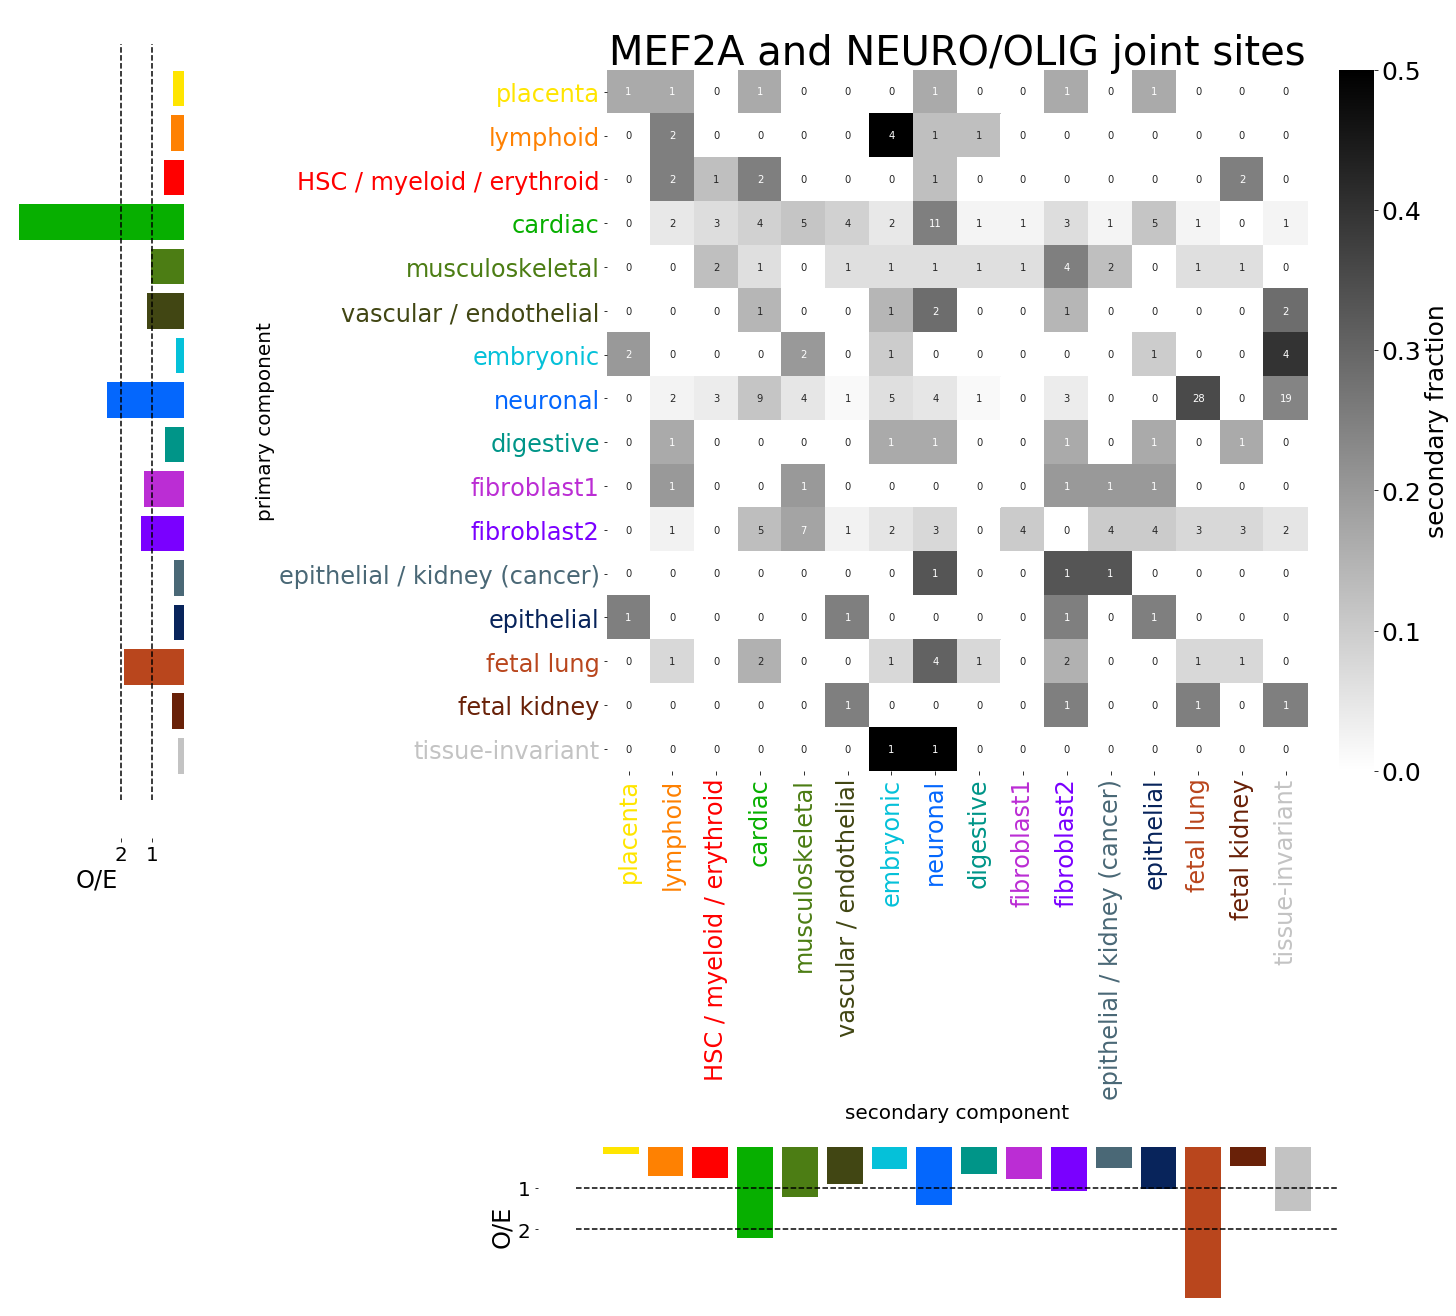

In [96]:
big_grid_plot(motif_pair_cut, plt_title='MEF2A and NEURO/OLIG joint sites')

To be continued

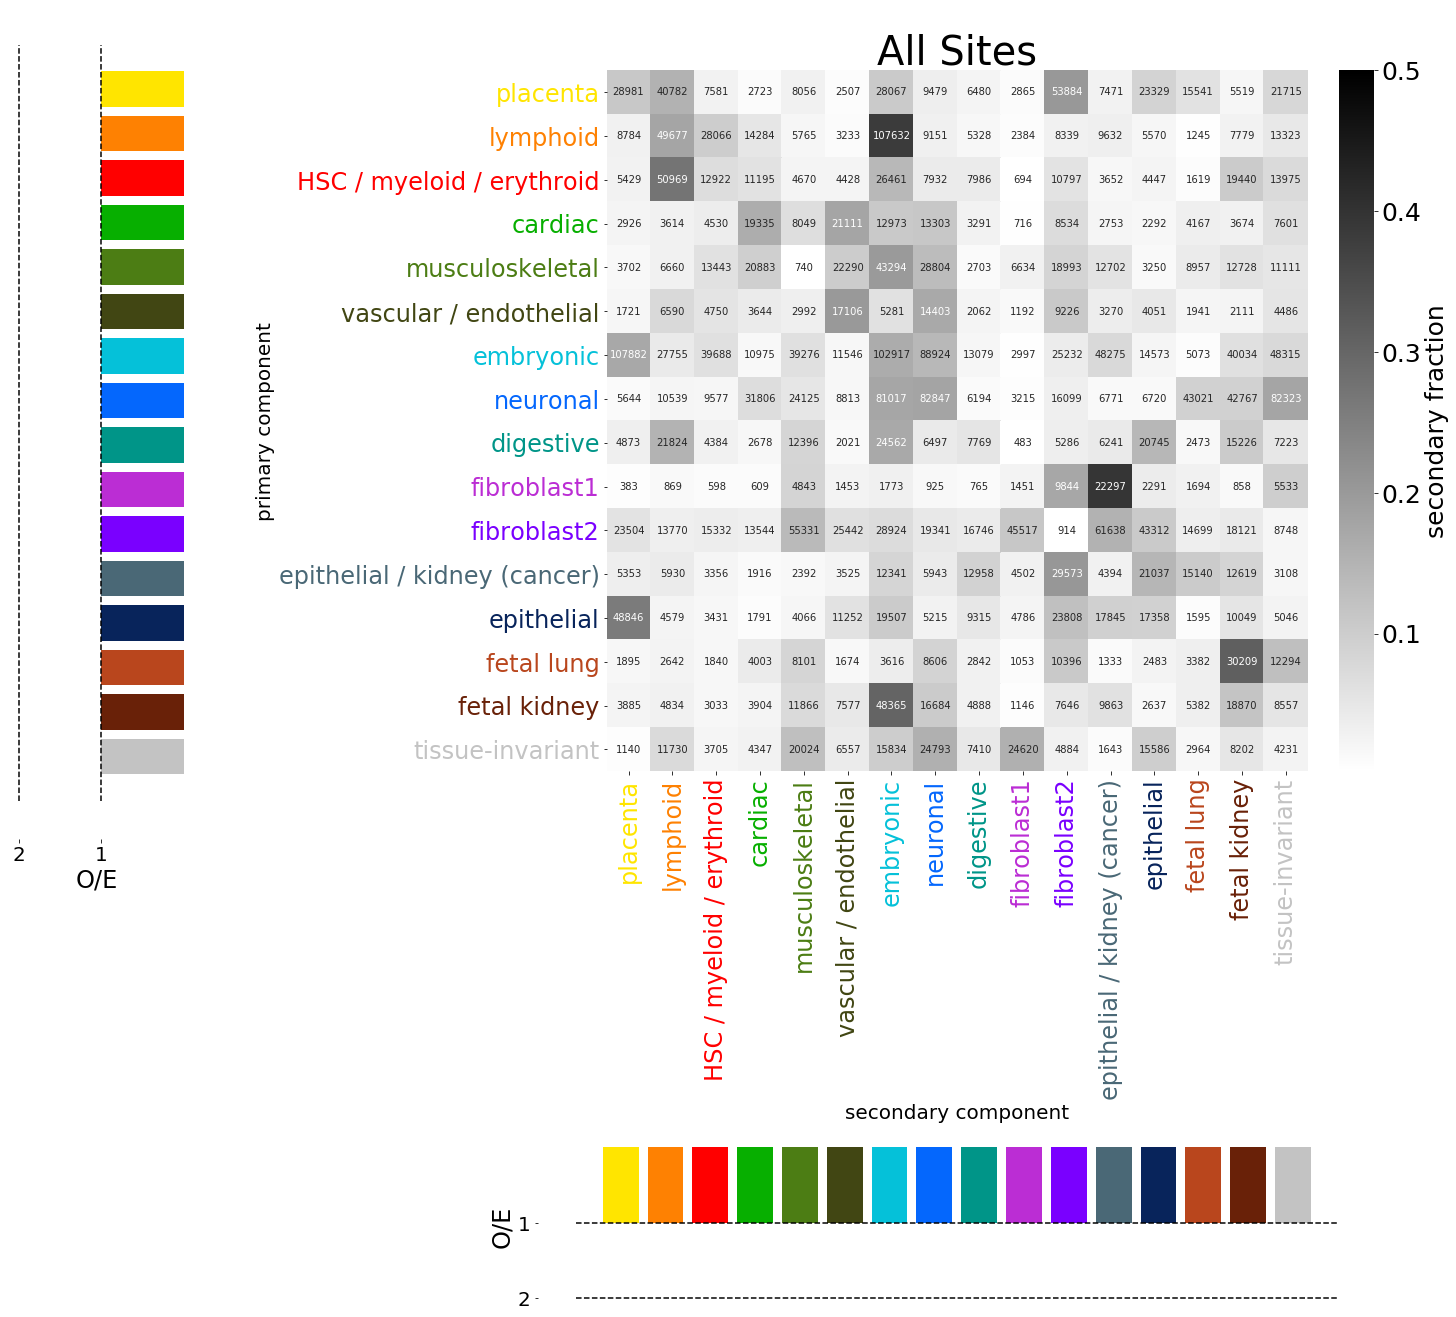

In [81]:
big_grid_plot(maxcolor>-1,plt_title='All Sites')

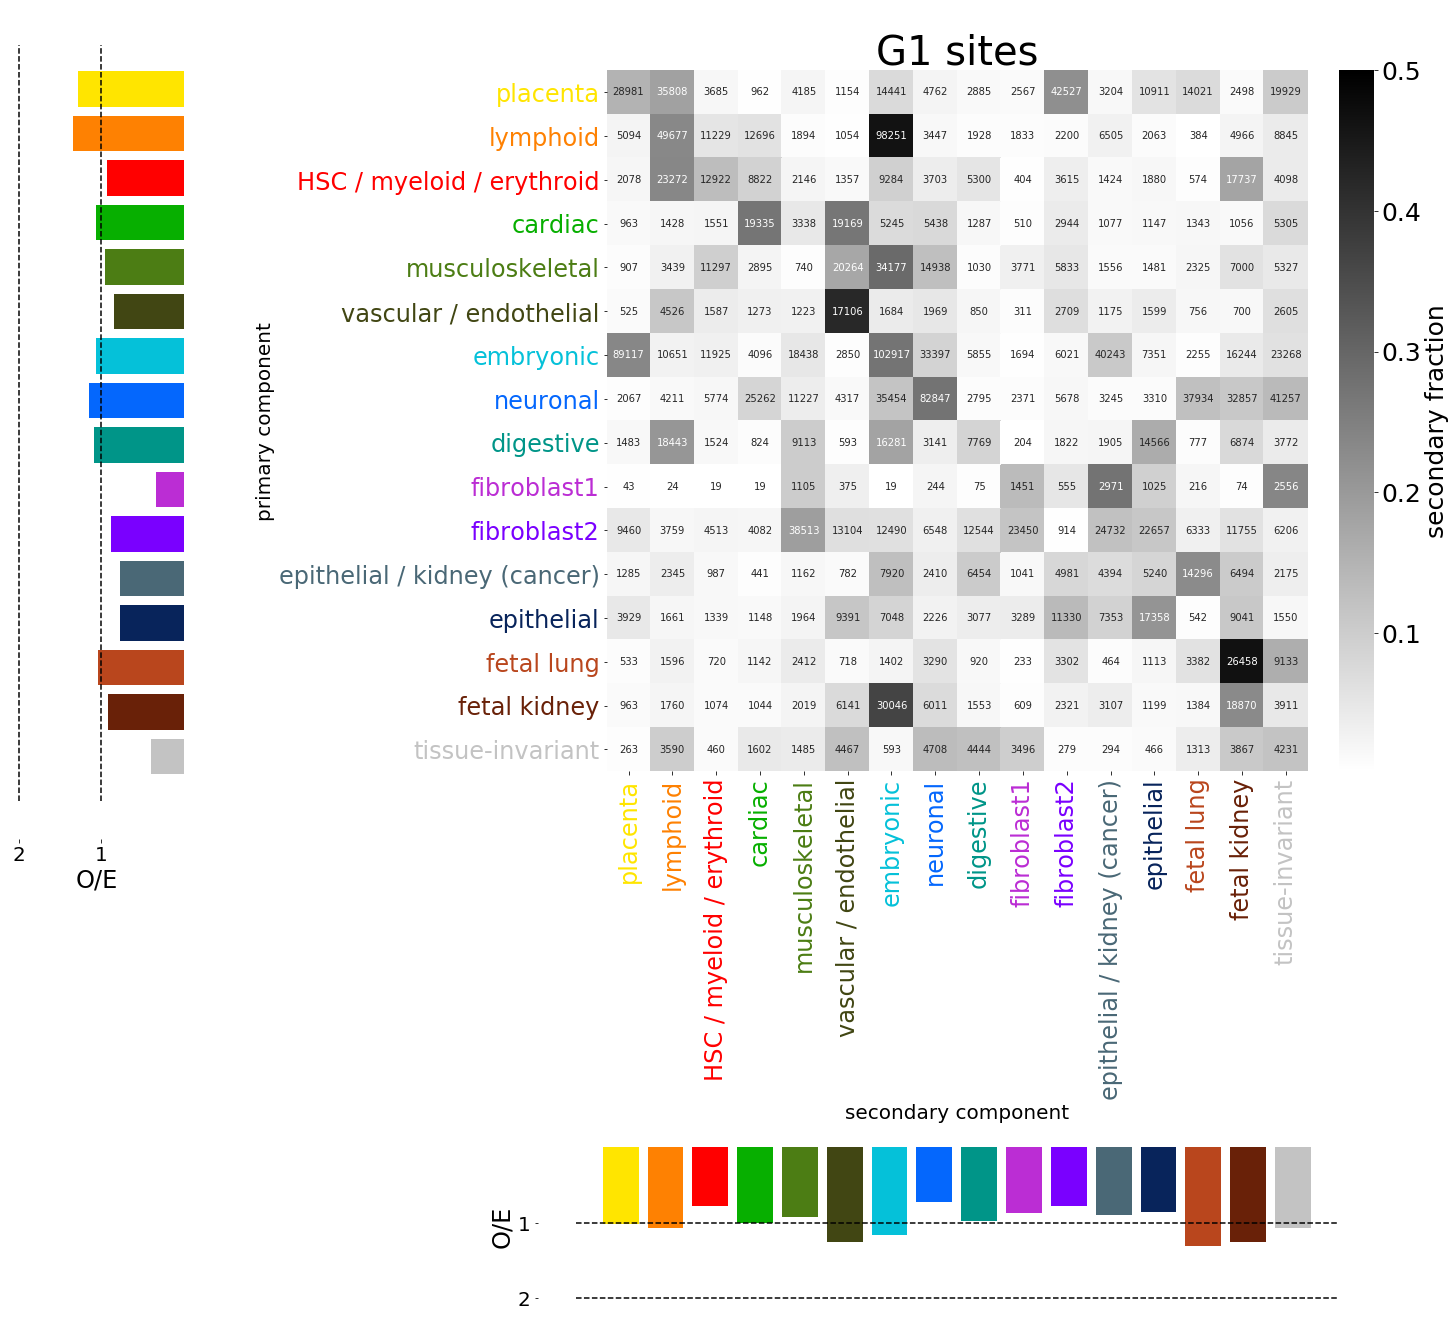

In [86]:
big_grid_plot(G1cut,plt_title='G1 sites')

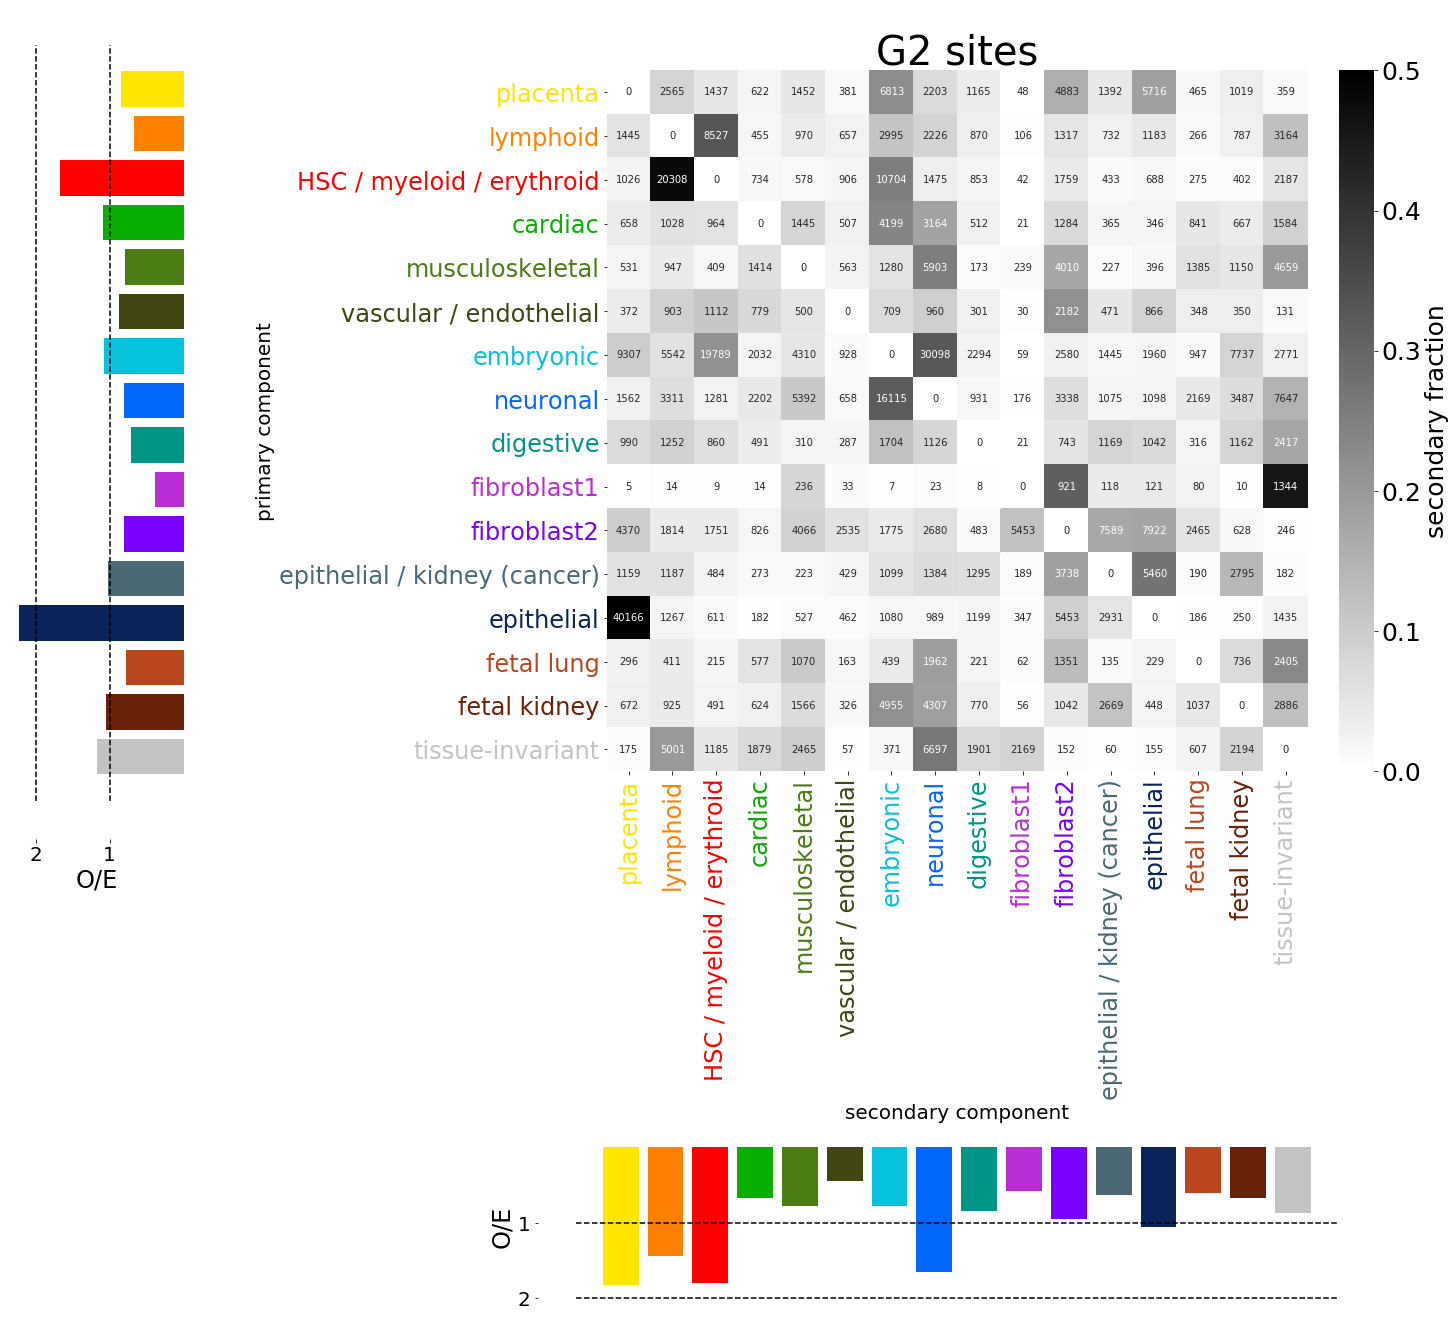

In [87]:
big_grid_plot(G2cut,plt_title='G2 sites')

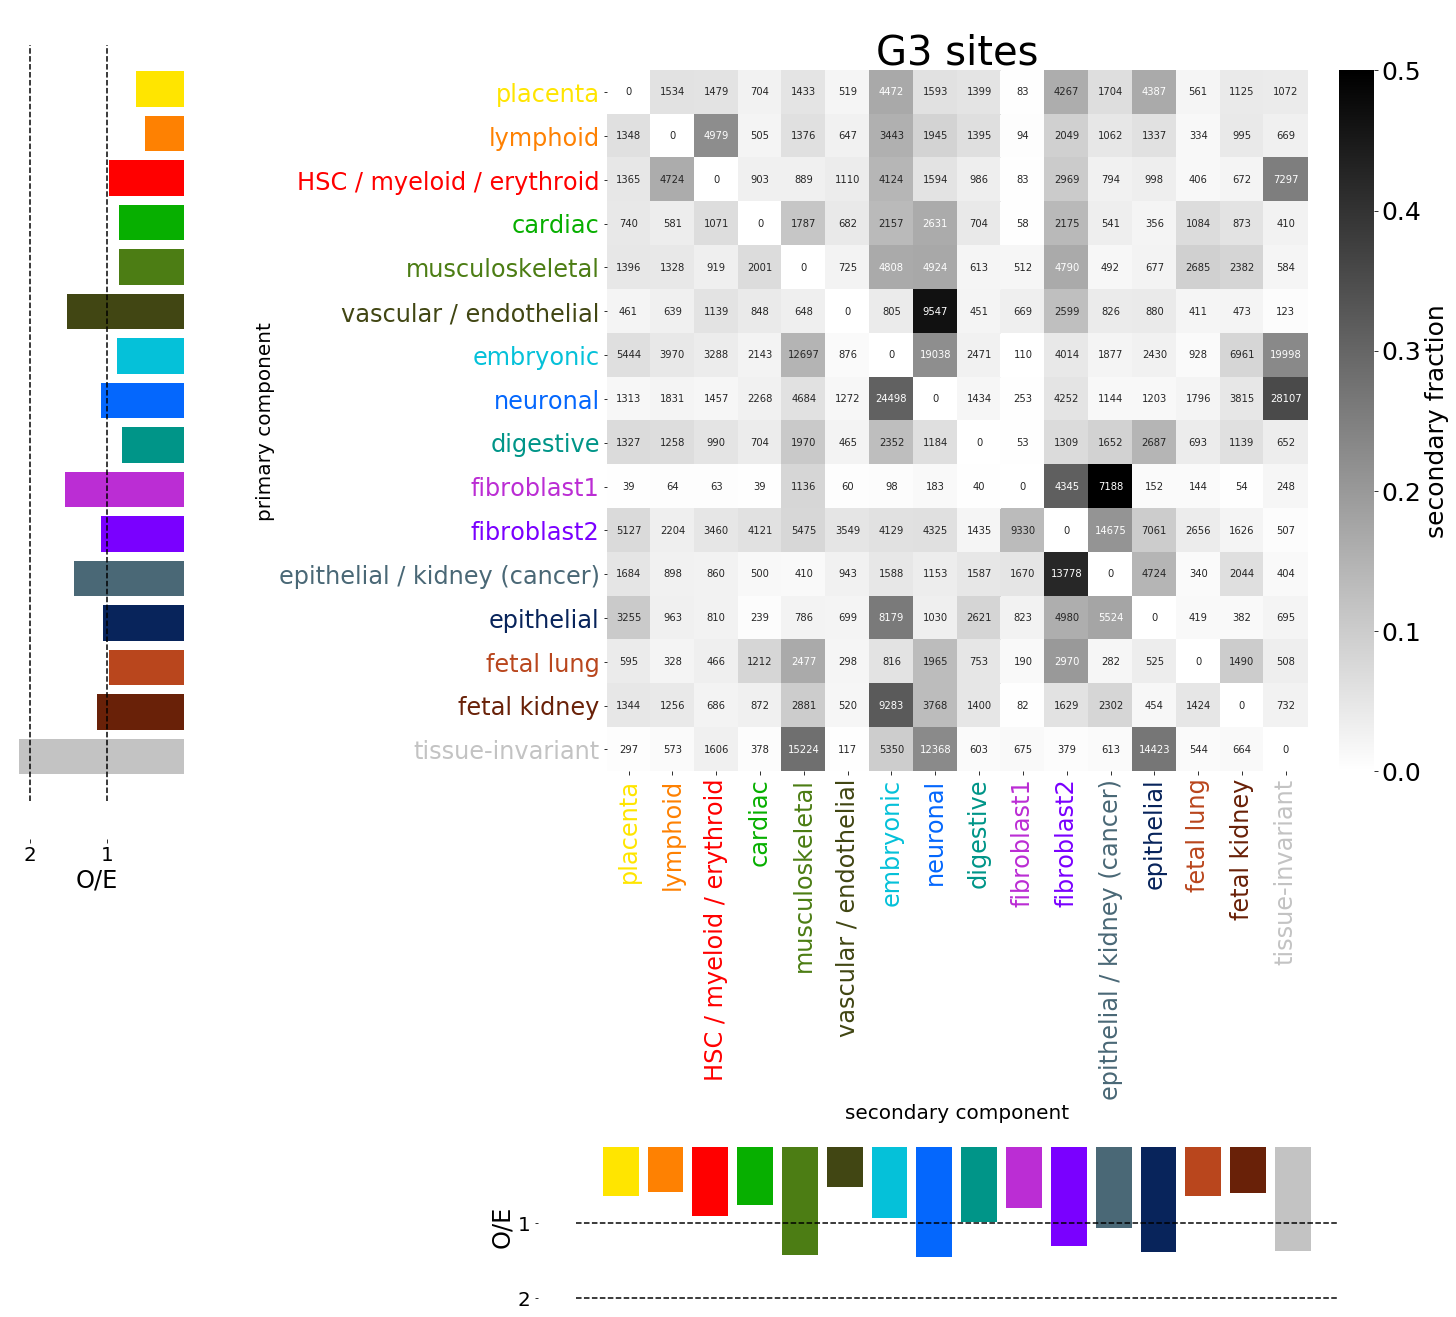

In [88]:
big_grid_plot(G3cut,plt_title='G3 sites')

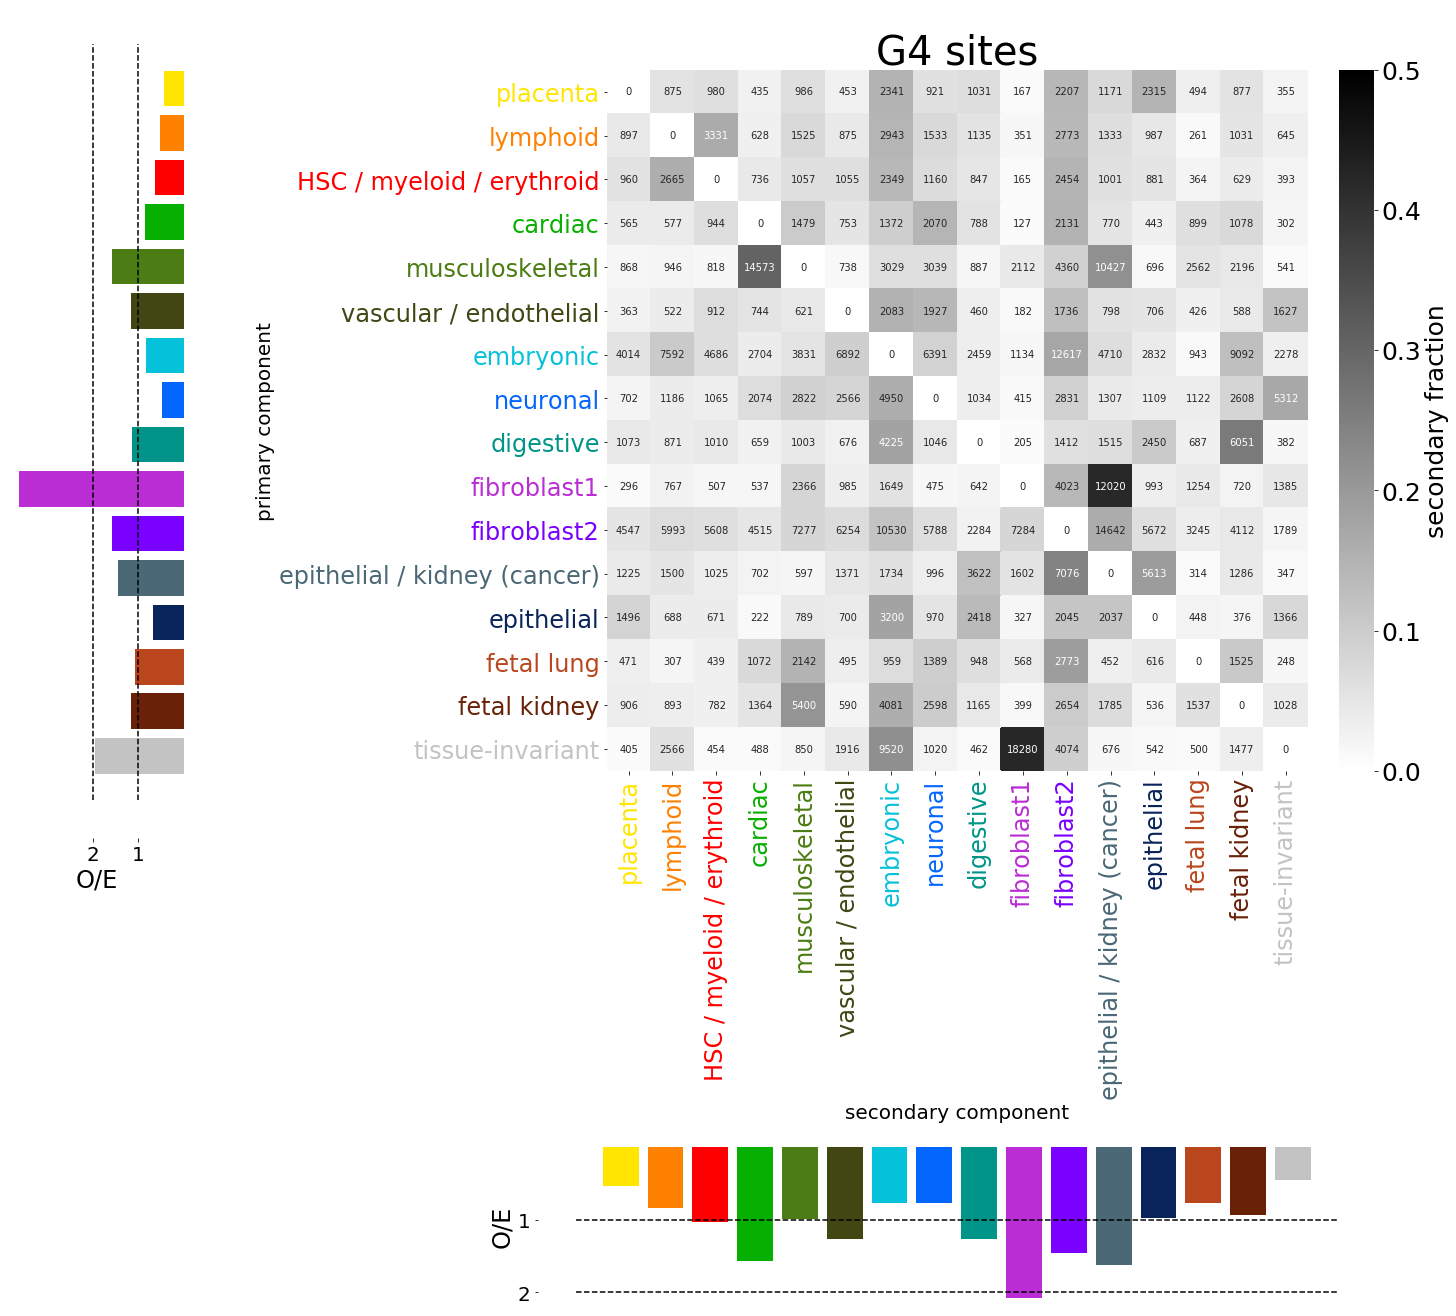

In [89]:
big_grid_plot(G4cut,plt_title='G4 sites')

Now time to try out OOE 

In [93]:
big_grid_plot(G4cut,plt_title='G4 sites',  logOOEmode = True, do_row_normalized_shading=False)

error, must pass return matrix


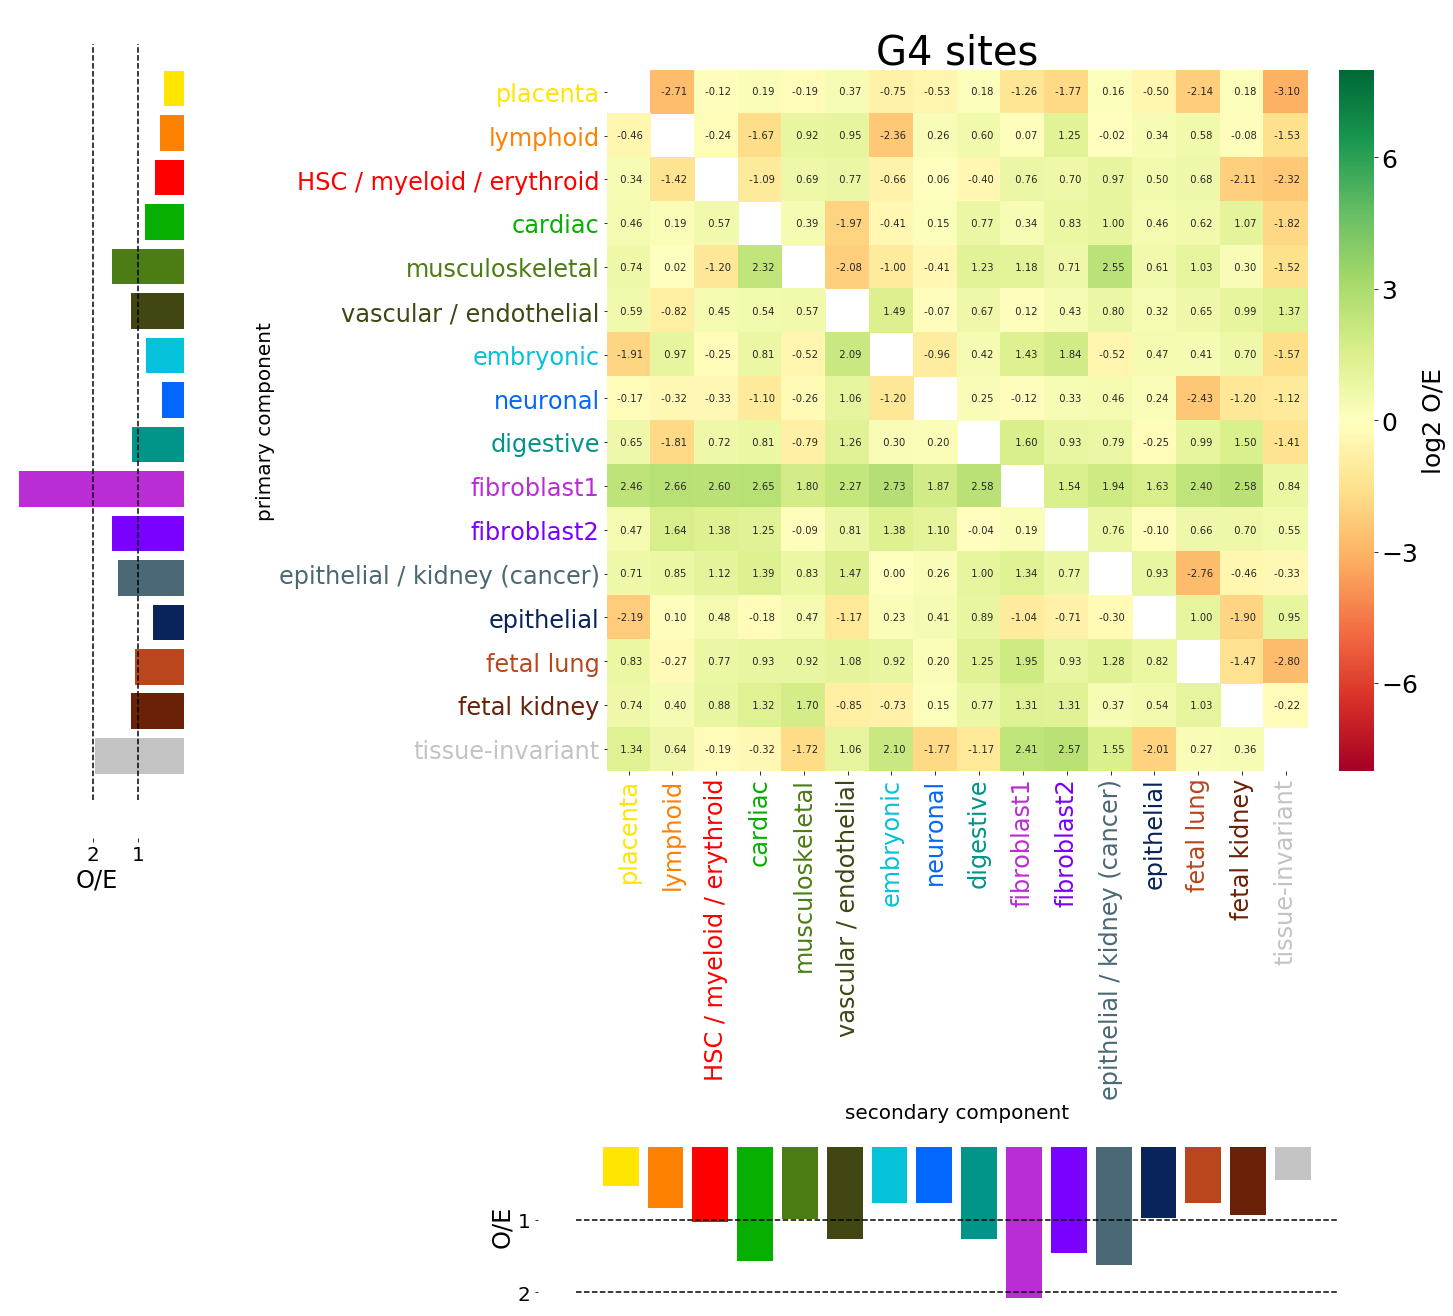

In [99]:
EM = return_expected_matrix(maxcolor>-1)
big_grid_plot(G4cut,plt_title='G4 sites',  logOOEmode = True, do_row_normalized_shading=False, ExpectedMatrix=EM)

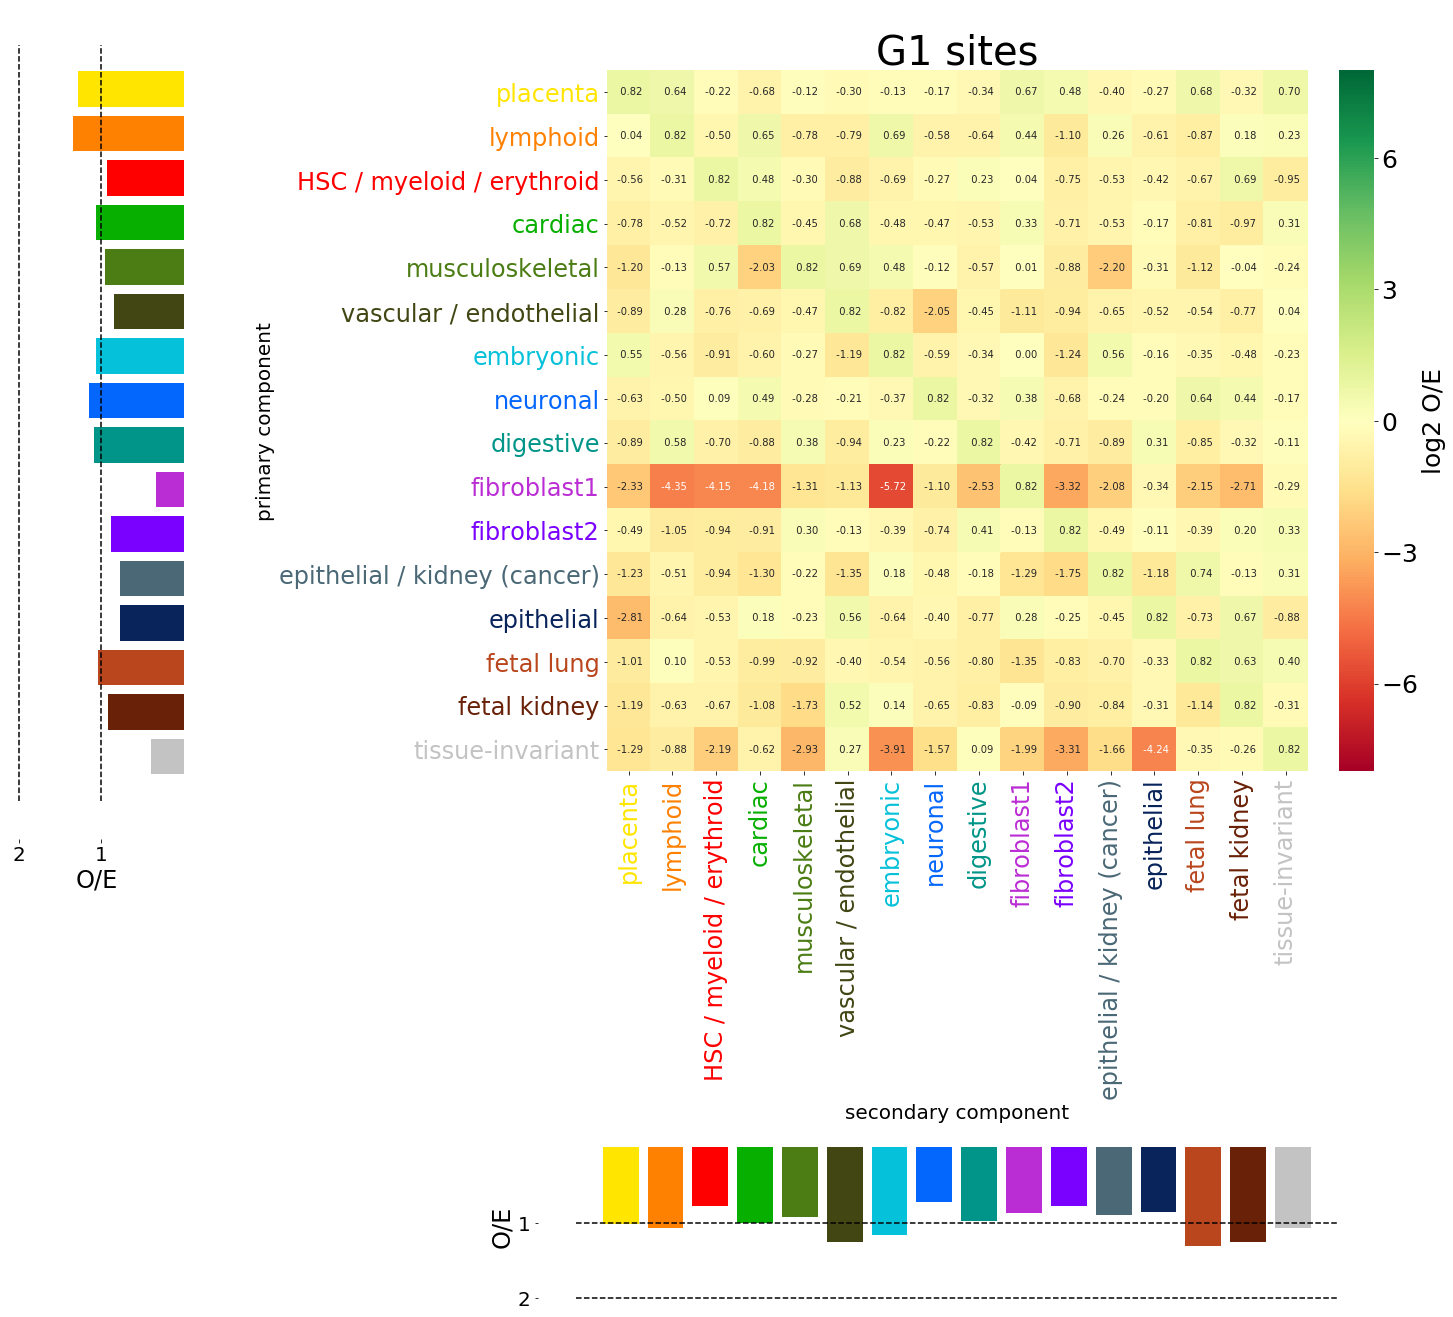

In [100]:
big_grid_plot(G1cut,plt_title='G1 sites',  logOOEmode = True, do_row_normalized_shading=False, ExpectedMatrix=EM)

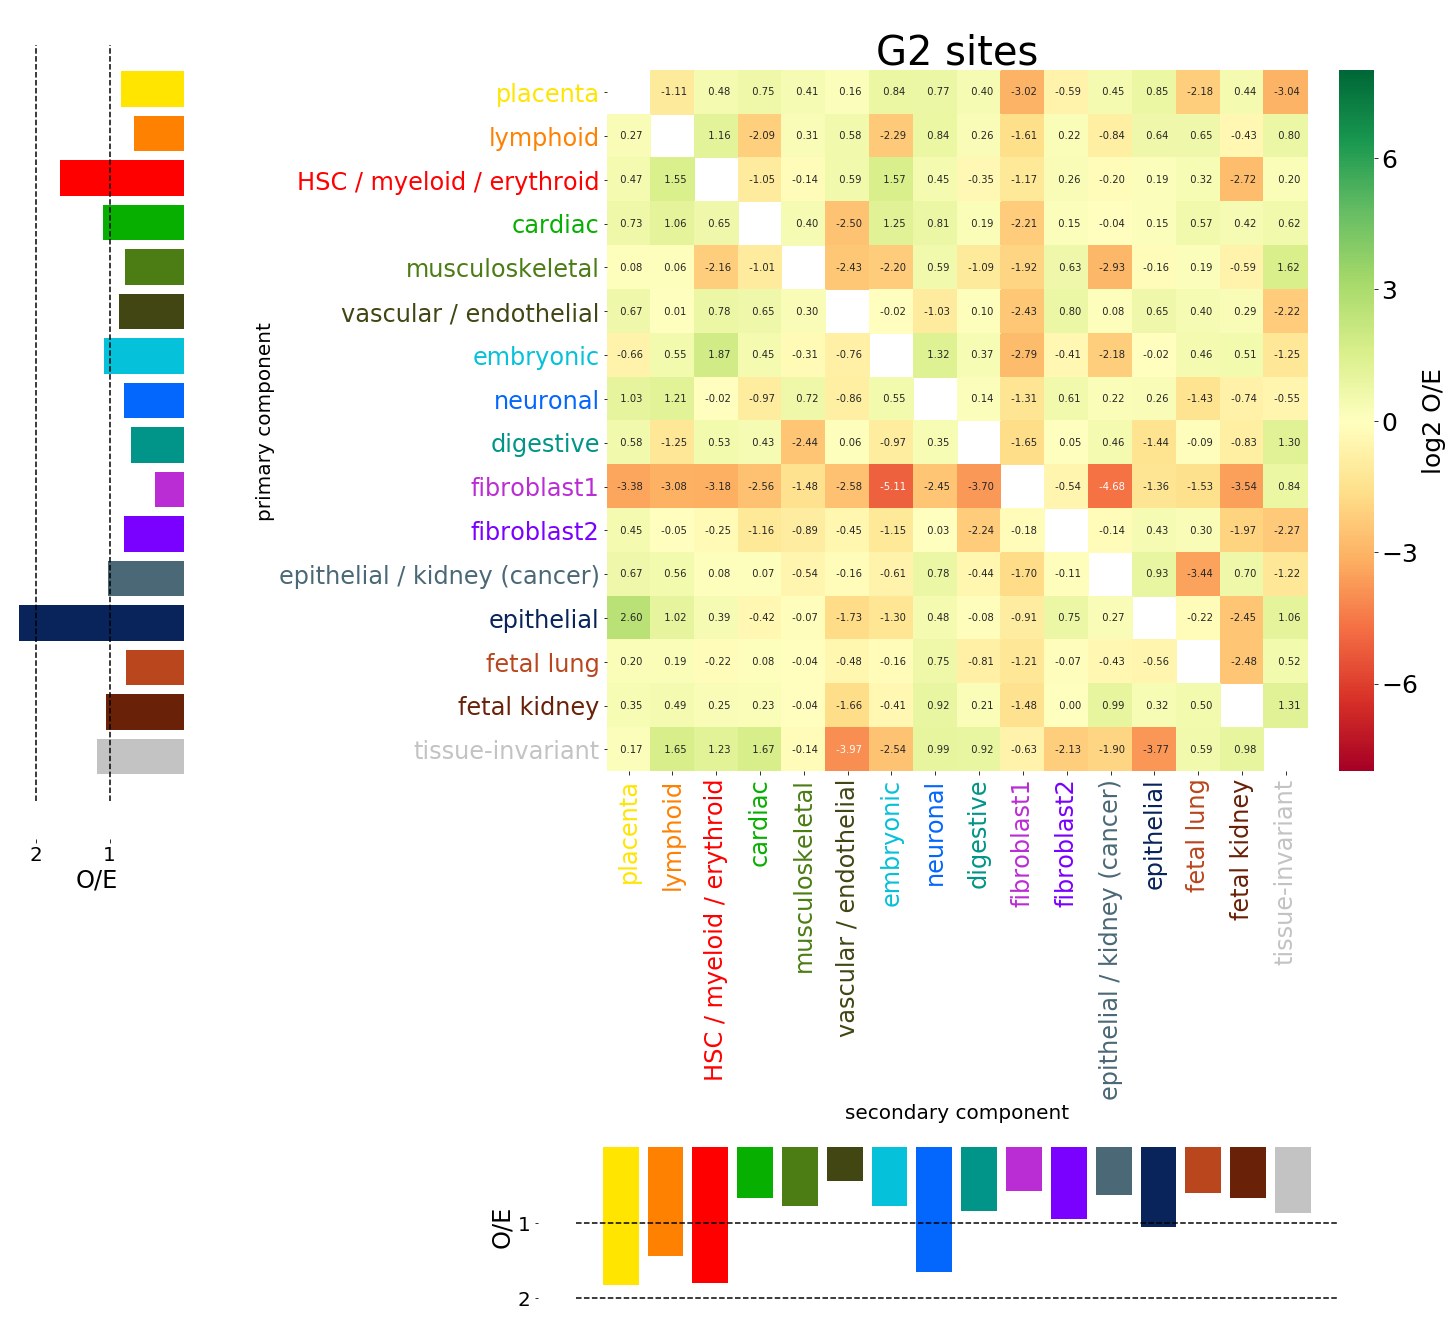

In [101]:
big_grid_plot(G2cut,plt_title='G2 sites',  logOOEmode = True, do_row_normalized_shading=False, ExpectedMatrix=EM)

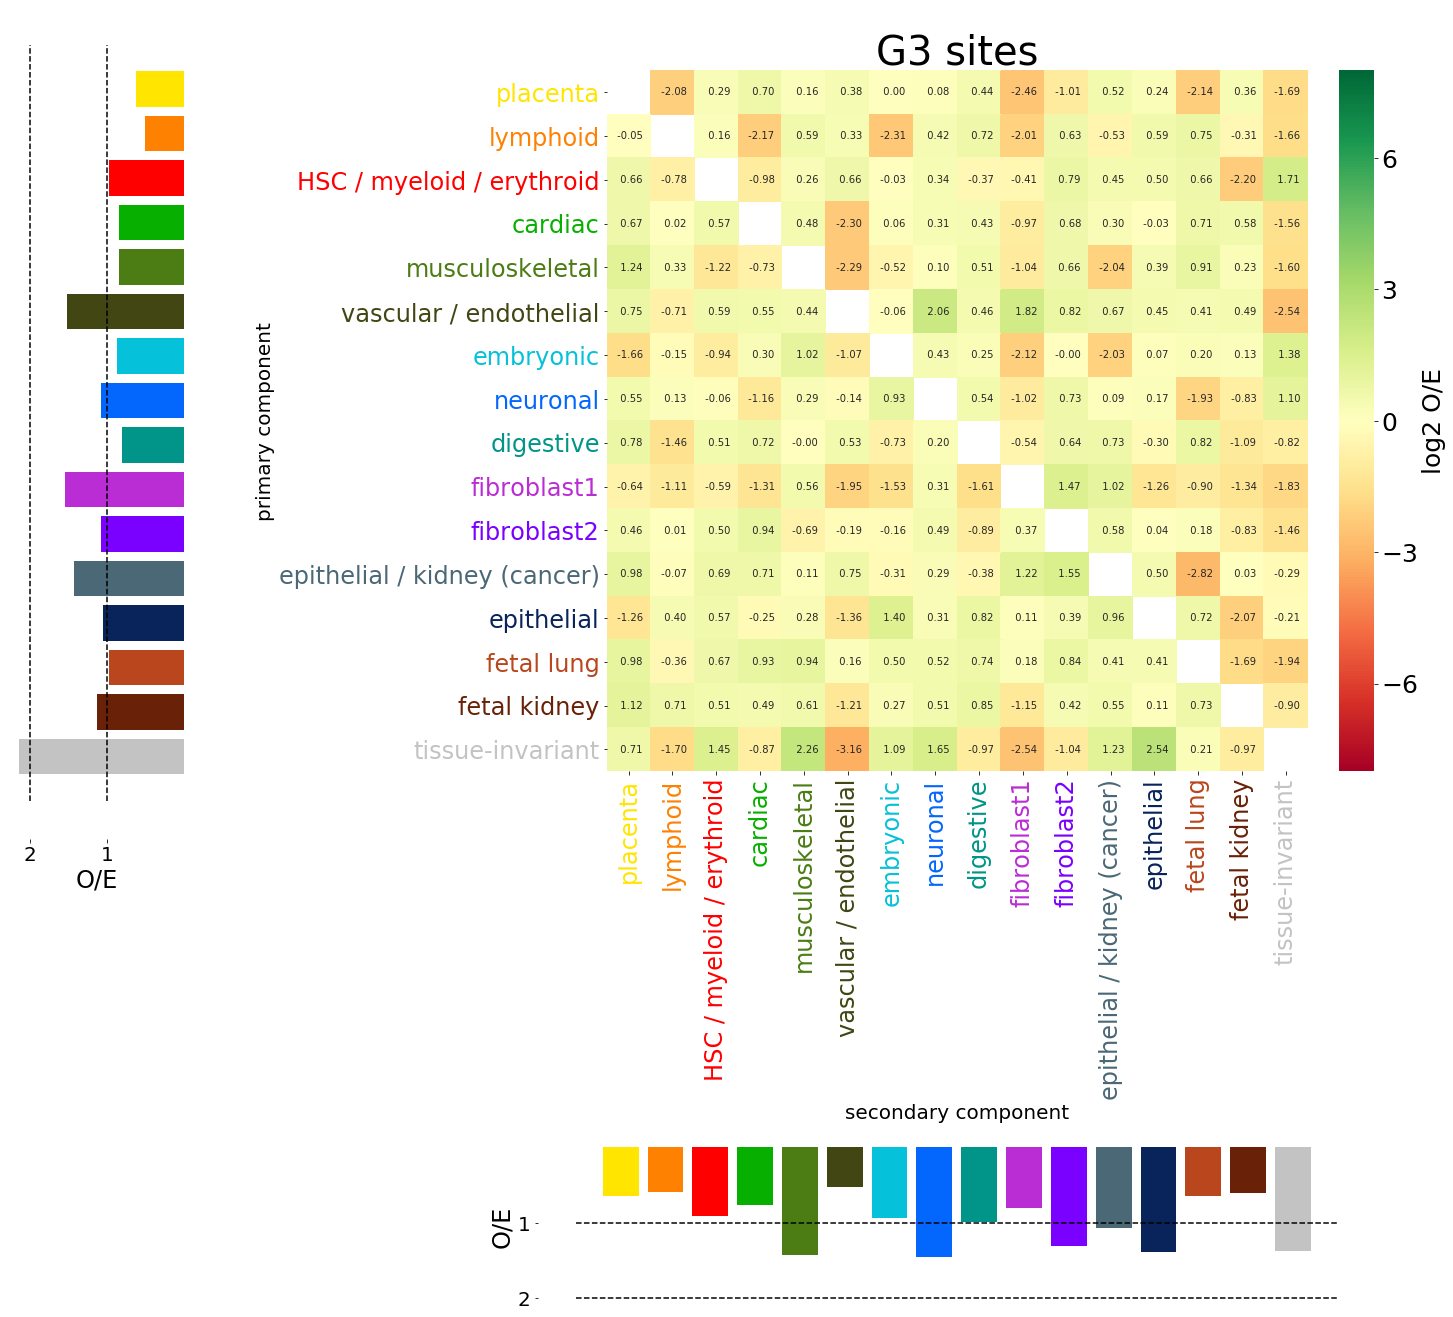

In [102]:
big_grid_plot(G3cut,plt_title='G3 sites',  logOOEmode = True, do_row_normalized_shading=False, ExpectedMatrix=EM)

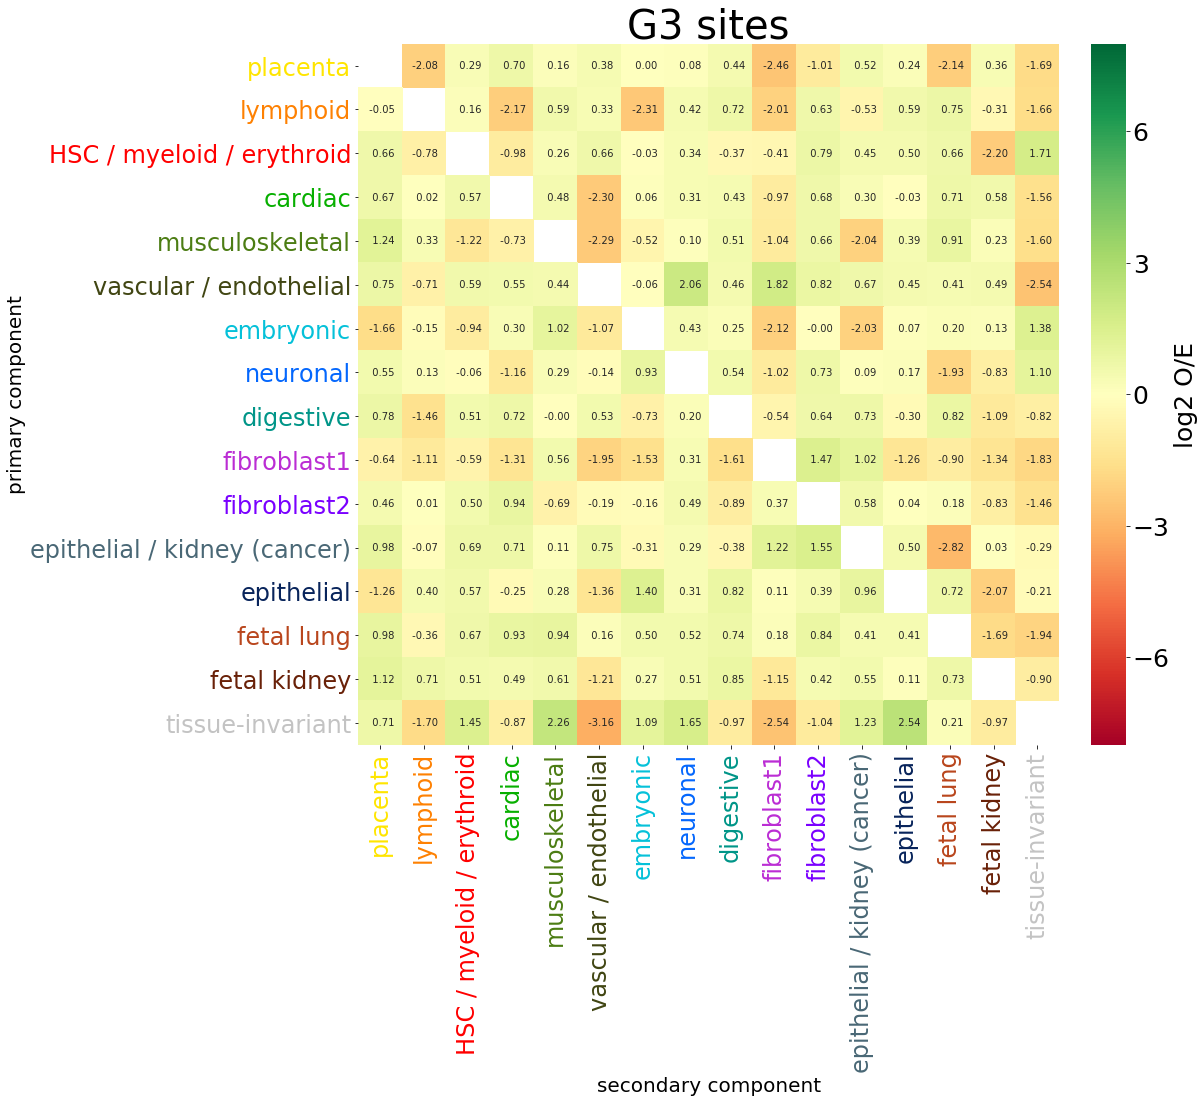

In [103]:
big_grid_plot(G3cut,plt_title='G3 sites',  logOOEmode = True, do_row_normalized_shading=False, ExpectedMatrix=EM, do_extra_bargraphs=False)

### Overall O/E for MEF2A and NEURO/OLIG sites

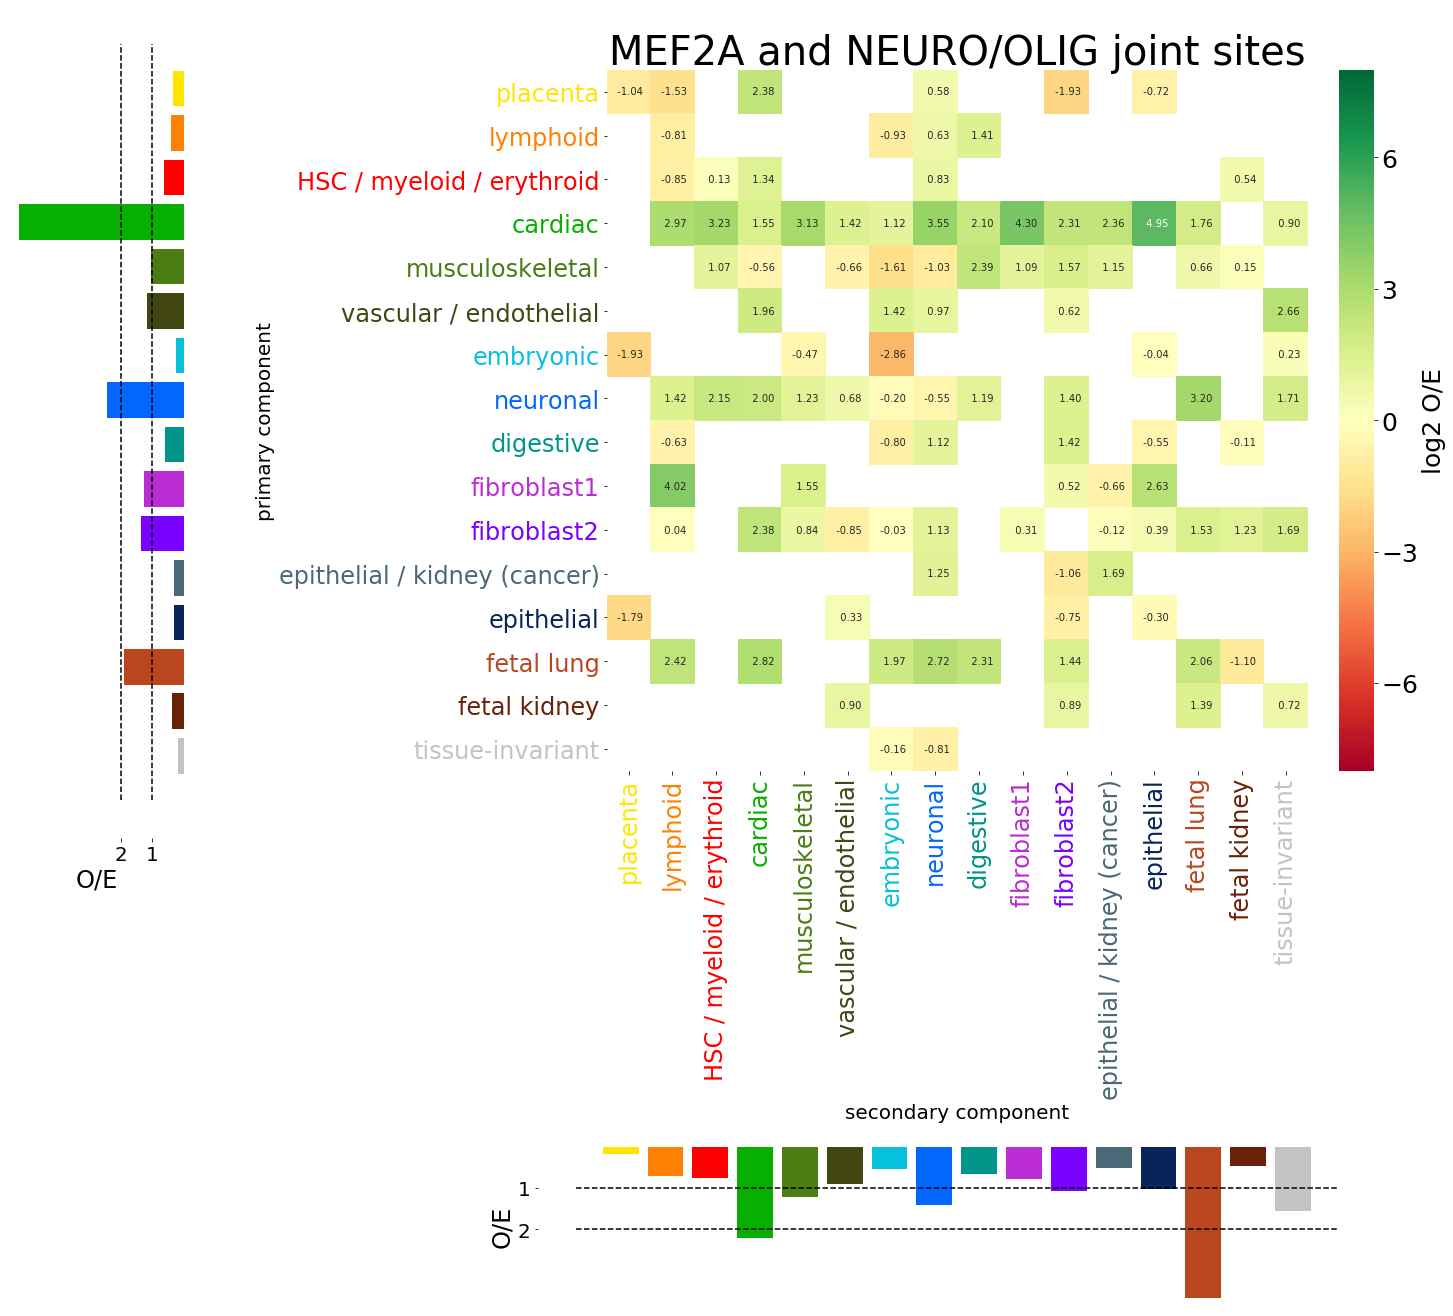

In [108]:
EM = return_expected_matrix(maxcolor>-1) 
big_grid_plot(motif_pair_cut,plt_title='MEF2A and NEURO/OLIG joint sites',  logOOEmode = True, do_row_normalized_shading=False, ExpectedMatrix=EM)

### now series of plot with individual groups of MEF2A joint NEURO/OLIG sites

first, lets use the group rates as expectation values

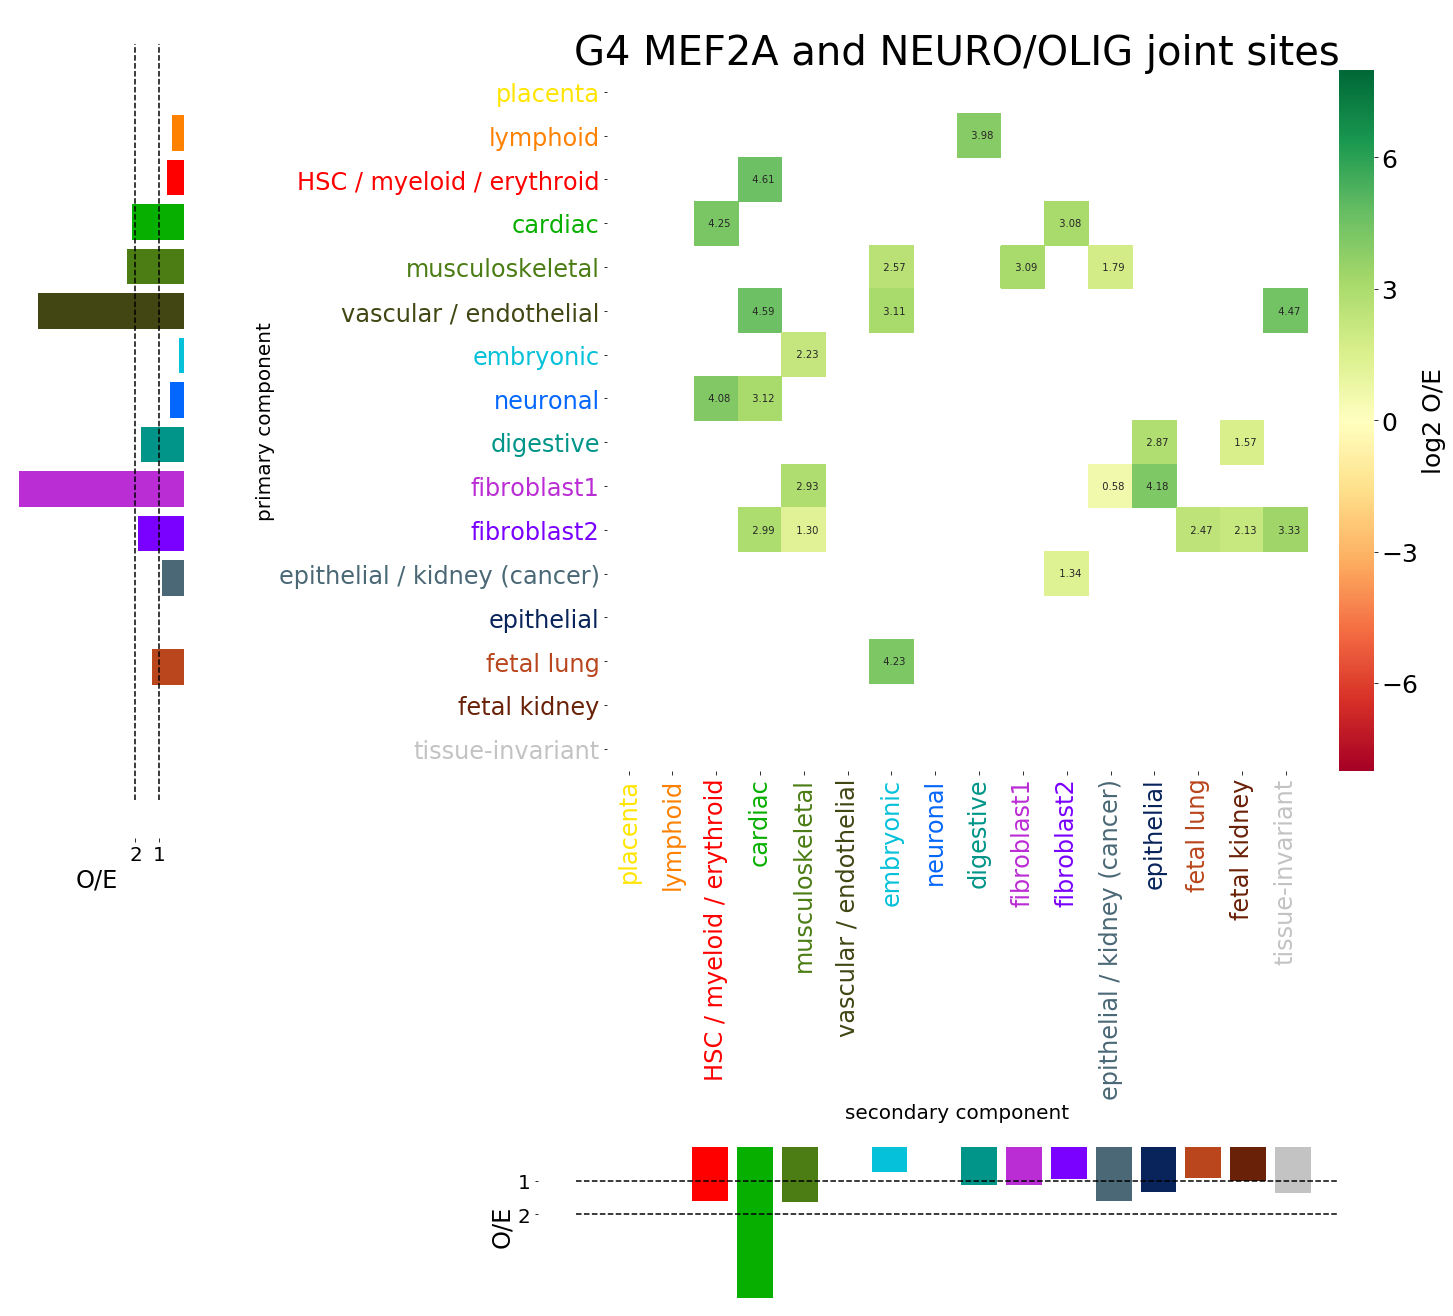

In [104]:
EM = return_expected_matrix(G4cut) 
big_grid_plot(G4cut*motif_pair_cut,plt_title='G4 MEF2A and NEURO/OLIG joint sites',  logOOEmode = True, do_row_normalized_shading=False, ExpectedMatrix=EM)

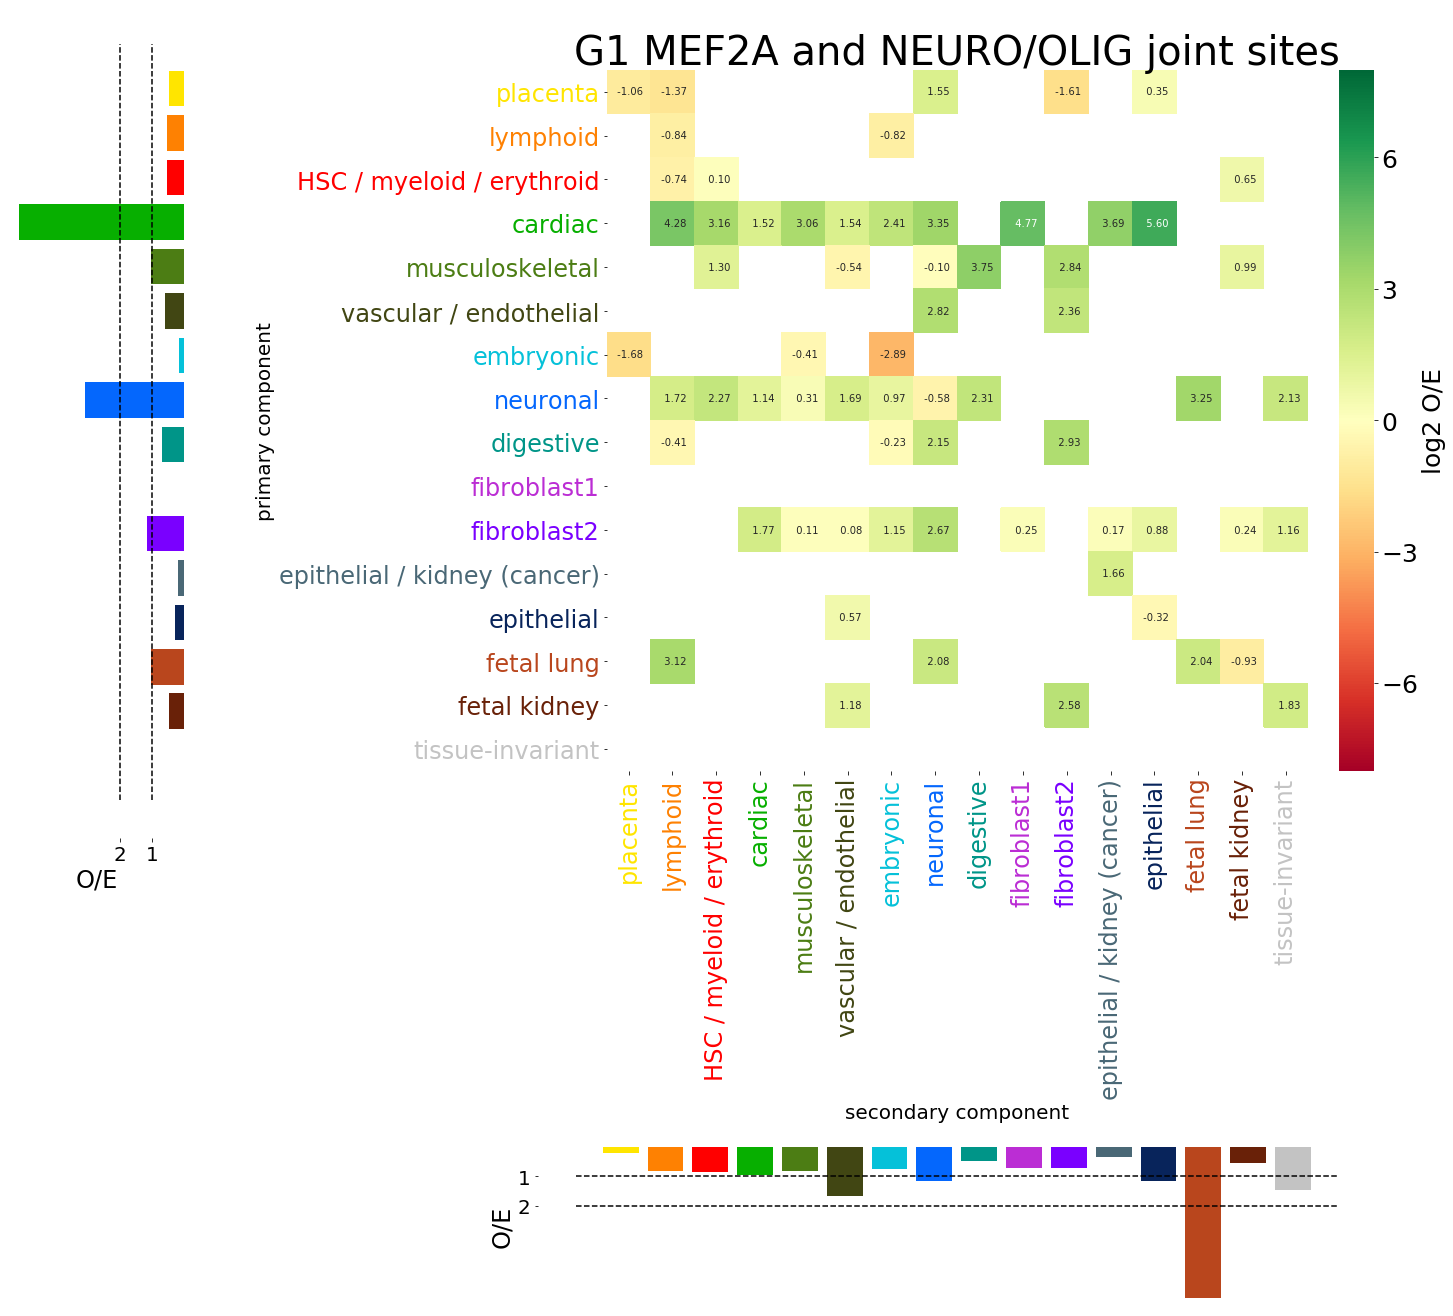

In [105]:
EM = return_expected_matrix(G1cut) 
big_grid_plot(G1cut*motif_pair_cut,plt_title='G1 MEF2A and NEURO/OLIG joint sites',  logOOEmode = True, do_row_normalized_shading=False, ExpectedMatrix=EM)

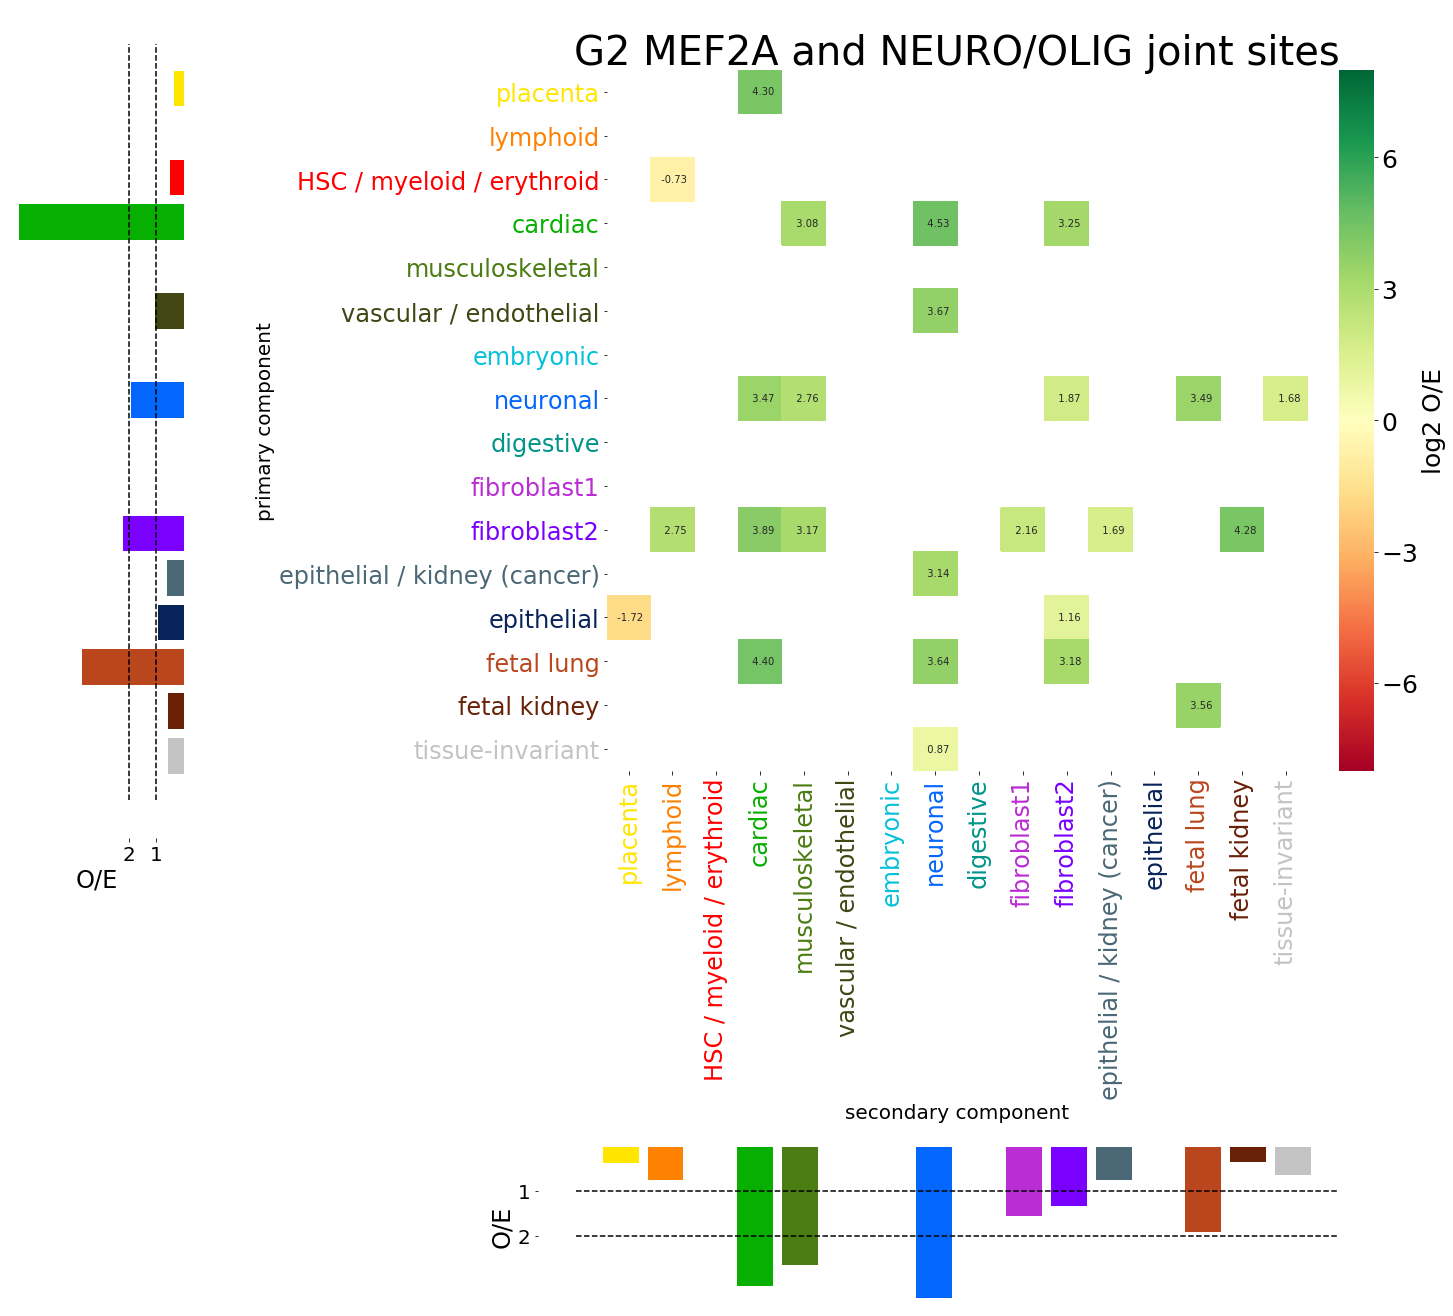

In [106]:
EM = return_expected_matrix(G2cut) 
big_grid_plot(G2cut*motif_pair_cut,plt_title='G2 MEF2A and NEURO/OLIG joint sites',  logOOEmode = True, do_row_normalized_shading=False, ExpectedMatrix=EM)

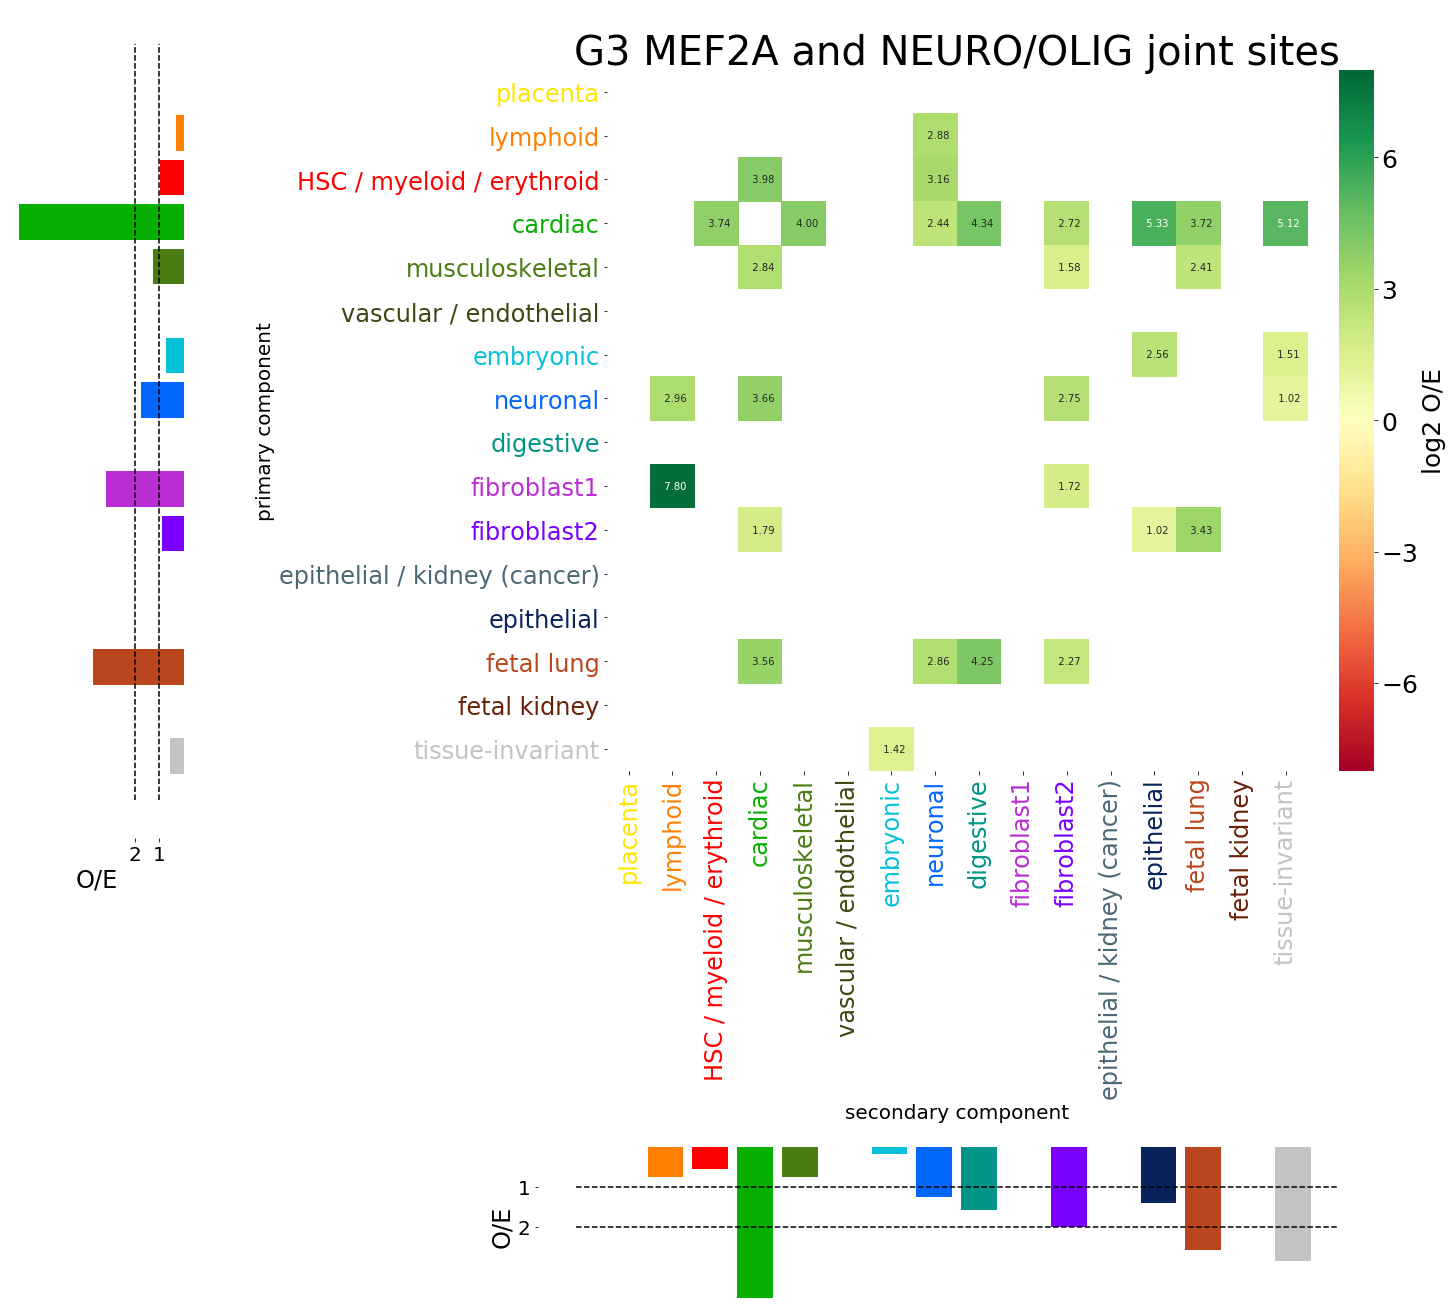

In [107]:
EM = return_expected_matrix(G3cut) 
big_grid_plot(G3cut*motif_pair_cut,plt_title='G3 MEF2A and NEURO/OLIG joint sites',  logOOEmode = True, do_row_normalized_shading=False, ExpectedMatrix=EM)

In [155]:
joint_motif_G2_pvalues = []
joint_motif_G2 = return_expected_matrix(G2cut * motif_pair_cut) 
all_matrix = return_expected_matrix(G2cut)
for main_comp in joint_motif_G2.columns.values[WSO]:
    pvalrow = []
    for second_comp in joint_motif_G2.columns.values[WSO]:
        print('main comp:', main_comp, 'second comp:',second_comp)
        YesYes = joint_motif_G2.loc[main_comp][second_comp]
        YesNo = joint_motif_G2.values.sum() - YesYes 
        NoYes = all_matrix.loc[main_comp][second_comp] - YesYes
        NoNo = all_matrix.values.sum() - YesNo - NoYes - YesYes
        my_p = fisher_exact([[YesYes, YesNo], [NoYes, NoNo]])
        print(my_p)
        pvalrow.append(my_p[1])
    
    joint_motif_G2_pvalues.append(pvalrow)
joint_motif_G2_pvalues = np.array(joint_motif_G2_pvalues)

main comp: placenta second comp: placenta
(nan, 1.0)
main comp: placenta second comp: lymphoid
(0.0, 1.0)
main comp: placenta second comp: HSC / myeloid / erythroid
(0.0, 1.0)
main comp: placenta second comp: cardiac
(20.140261777942936, 0.04969508713690986)
main comp: placenta second comp: musculoskeletal
(0.0, 1.0)
main comp: placenta second comp: vascular / endothelial
(0.0, 1.0)
main comp: placenta second comp: embryonic
(0.0, 1.0)
main comp: placenta second comp: neuronal
(0.0, 1.0)
main comp: placenta second comp: digestive
(0.0, 1.0)
main comp: placenta second comp: fibroblast1
(0.0, 1.0)
main comp: placenta second comp: fibroblast2
(0.0, 1.0)
main comp: placenta second comp: epithelial / kidney (cancer)
(0.0, 1.0)
main comp: placenta second comp: epithelial
(0.0, 1.0)
main comp: placenta second comp: fetal lung
(0.0, 1.0)
main comp: placenta second comp: fetal kidney
(0.0, 1.0)
main comp: placenta second comp: tissue-invariant
(0.0, 1.0)
main comp: lymphoid second comp: placent

(4.663045892110573, 0.07355326330310138)
main comp: fibroblast2 second comp: fibroblast2
(nan, 1.0)
main comp: fibroblast2 second comp: epithelial / kidney (cancer)
(3.3354213925481955, 0.12801813291380754)
main comp: fibroblast2 second comp: epithelial
(0.0, 1.0)
main comp: fibroblast2 second comp: fetal lung
(0.0, 1.0)
main comp: fibroblast2 second comp: fetal kidney
(19.947286631497157, 0.050162532998968765)
main comp: fibroblast2 second comp: tissue-invariant
(0.0, 1.0)
main comp: epithelial / kidney (cancer) second comp: placenta
(0.0, 1.0)
main comp: epithelial / kidney (cancer) second comp: lymphoid
(0.0, 1.0)
main comp: epithelial / kidney (cancer) second comp: HSC / myeloid / erythroid
(0.0, 1.0)
main comp: epithelial / kidney (cancer) second comp: cardiac
(0.0, 1.0)
main comp: epithelial / kidney (cancer) second comp: musculoskeletal
(0.0, 1.0)
main comp: epithelial / kidney (cancer) second comp: vascular / endothelial
(0.0, 1.0)
main comp: epithelial / kidney (cancer) second

In [118]:
joint_motif_G2_pvalues

array([[1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 4.24352028e-01,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.76226634e-01,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 4.11073746e-01, 1.00000000e+00],
       [1.00000000e+00, 7.35532633e-02, 1.00000000e+00, 1.00000000e+00,
        1.38291029e-01, 1.28018133e-01, 1.00000000e+00, 1.000

In [120]:
(joint_motif_G2_pvalues < 1e-5).sum()

1

In [123]:
EM = return_expected_matrix(G2cut) 


(16, 16)


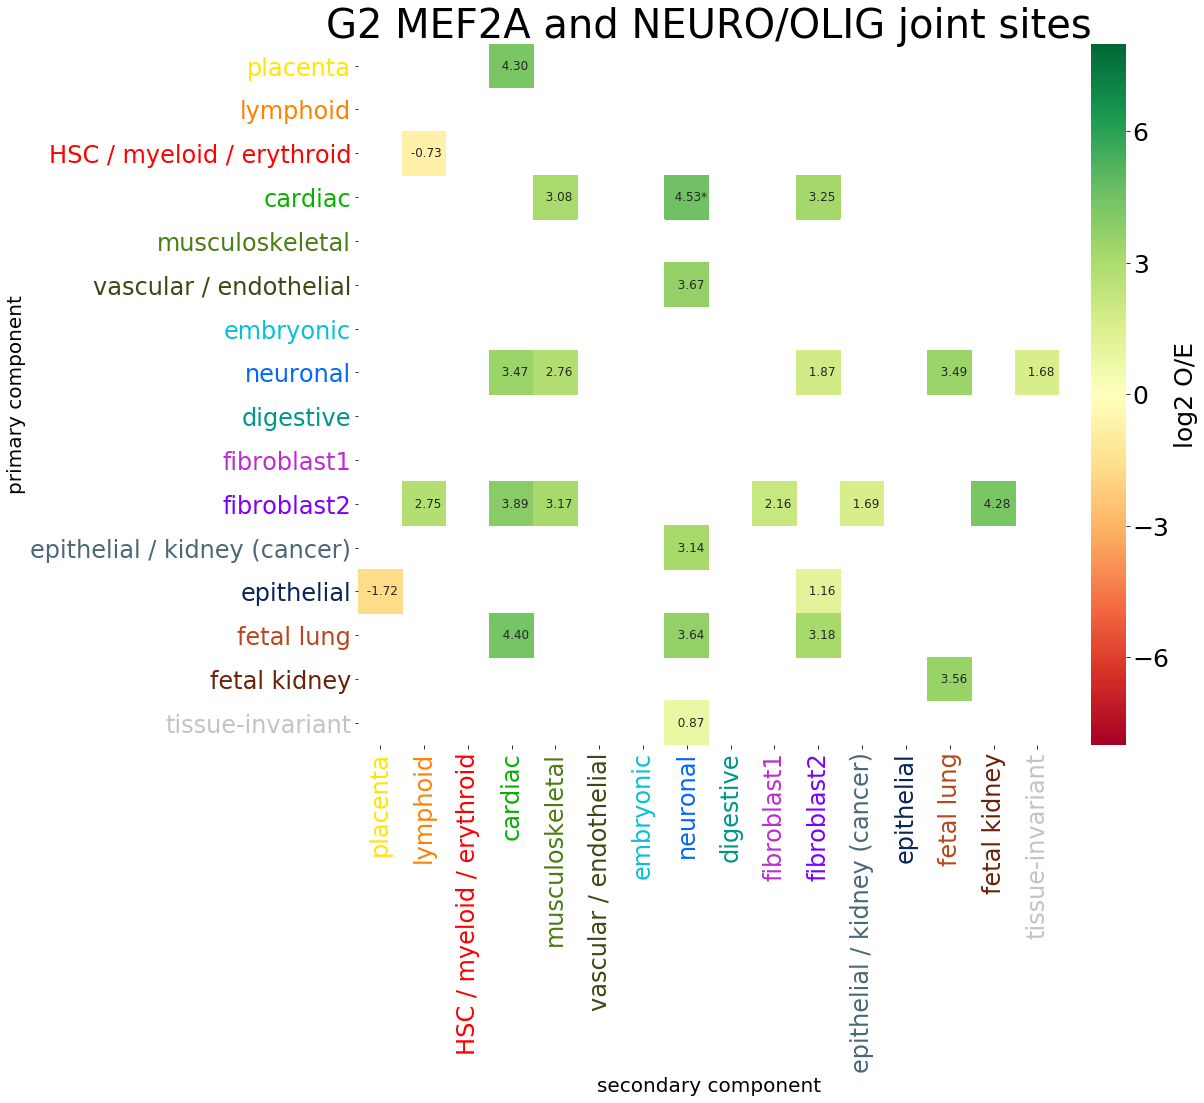

In [168]:
big_grid_plot(G2cut*motif_pair_cut,plt_title='G2 MEF2A and NEURO/OLIG joint sites',  logOOEmode = True, do_row_normalized_shading=False, ExpectedMatrix=EM, adjust_significance=True, do_extra_bargraphs=False, pmatrix = (joint_motif_G2_pvalues < 1e-5))

main comp: placenta second comp: placenta
(nan, 1.0)
main comp: placenta second comp: lymphoid
(0.0, 1.0)
main comp: placenta second comp: HSC / myeloid / erythroid
(0.0, 1.0)
main comp: placenta second comp: cardiac
(20.140261777942936, 0.04969508713690986)
main comp: placenta second comp: musculoskeletal
(0.0, 1.0)
main comp: placenta second comp: vascular / endothelial
(0.0, 1.0)
main comp: placenta second comp: embryonic
(0.0, 1.0)
main comp: placenta second comp: neuronal
(0.0, 1.0)
main comp: placenta second comp: digestive
(0.0, 1.0)
main comp: placenta second comp: fibroblast1
(0.0, 1.0)
main comp: placenta second comp: fibroblast2
(0.0, 1.0)
main comp: placenta second comp: epithelial / kidney (cancer)
(0.0, 1.0)
main comp: placenta second comp: epithelial
(0.0, 1.0)
main comp: placenta second comp: fetal lung
(0.0, 1.0)
main comp: placenta second comp: fetal kidney
(0.0, 1.0)
main comp: placenta second comp: tissue-invariant
(0.0, 1.0)
main comp: lymphoid second comp: placent

(6.881709024566168, 0.13829102939122578)
main comp: fibroblast2 second comp: HSC / myeloid / erythroid
(0.0, 1.0)
main comp: fibroblast2 second comp: cardiac
(15.153783993783994, 0.06546310440233263)
main comp: fibroblast2 second comp: musculoskeletal
(9.665371746346395, 0.004526031702212632)
main comp: fibroblast2 second comp: vascular / endothelial
(0.0, 1.0)
main comp: fibroblast2 second comp: embryonic
(0.0, 1.0)
main comp: fibroblast2 second comp: neuronal
(0.0, 1.0)
main comp: fibroblast2 second comp: digestive
(0.0, 1.0)
main comp: fibroblast2 second comp: fibroblast1
(4.663045892110573, 0.07355326330310138)
main comp: fibroblast2 second comp: fibroblast2
(nan, 1.0)
main comp: fibroblast2 second comp: epithelial / kidney (cancer)
(3.3354213925481955, 0.12801813291380754)
main comp: fibroblast2 second comp: epithelial
(0.0, 1.0)
main comp: fibroblast2 second comp: fetal lung
(0.0, 1.0)
main comp: fibroblast2 second comp: fetal kidney
(19.947286631497157, 0.050162532998968765)
mai

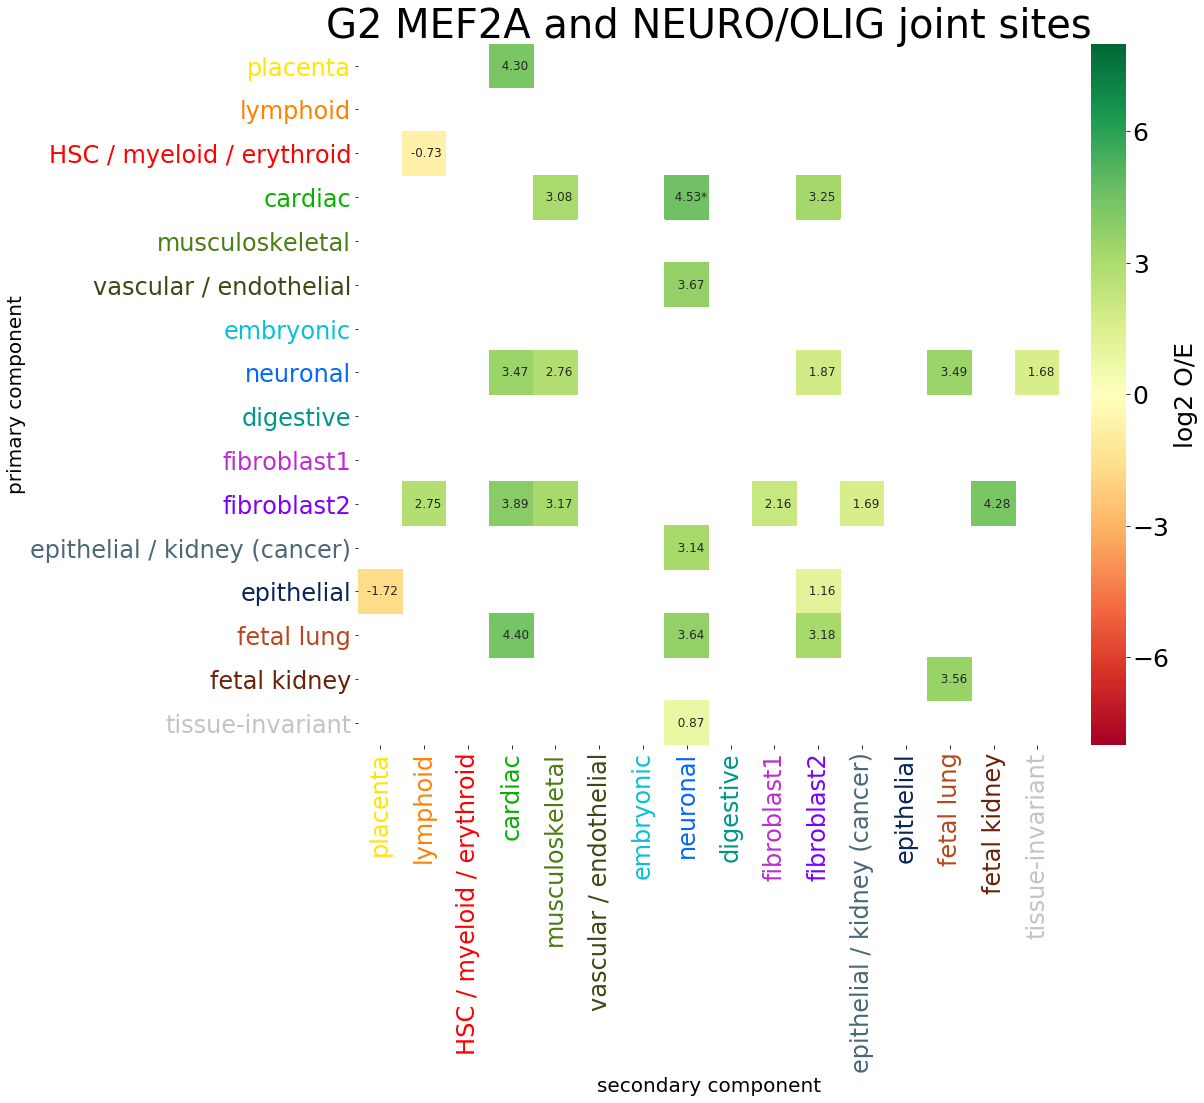

In [169]:
EM = return_expected_matrix(G2cut) 

joint_motif_G2_pvalues = []
joint_motif_G2 = return_expected_matrix(G2cut * motif_pair_cut) 
all_matrix = return_expected_matrix(G2cut)
for main_comp in joint_motif_G2.columns.values[WSO]:
    pvalrow = []
    for second_comp in joint_motif_G2.columns.values[WSO]:
        #print('main comp:', main_comp, 'second comp:',second_comp)
        YesYes = joint_motif_G2.loc[main_comp][second_comp]
        YesNo = joint_motif_G2.values.sum() - YesYes 
        NoYes = all_matrix.loc[main_comp][second_comp] - YesYes
        NoNo = all_matrix.values.sum() - YesNo - NoYes - YesYes
        my_p = fisher_exact([[YesYes, YesNo], [NoYes, NoNo]])
        print(my_p)
        pvalrow.append(my_p[1])
    
    joint_motif_G2_pvalues.append(pvalrow)
joint_motif_G2_pvalues = np.array(joint_motif_G2_pvalues)

big_grid_plot(G2cut*motif_pair_cut,plt_title='G2 MEF2A and NEURO/OLIG joint sites',  logOOEmode = True, do_row_normalized_shading=False, ExpectedMatrix=EM, adjust_significance=True, do_extra_bargraphs=False, pmatrix = (joint_motif_G2_pvalues < 1e-5))


(nan, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(nan, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(7.511541099504062, 0.12748448553048805)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(nan, 1.0)
(16.21857410881801, 0.061297400105863764)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(9.172276144027556, 0.1057141931675305)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(13.668080517613229, 0.07229017066516931)
(nan, 1.0)
(16.796520713548578, 0.007044759611182786)
(0.0, 1.0)
(0.0, 1.0)
(5.545568879789412, 0.1685509646428939)
(20.816865448444396, 0.04811182180253905)
(0.0, 1.0)
(6.714139126742623, 0.14146876522460666)
(0.0, 1.0)
(41.24839292163236, 0.024618318381231224)
(13.503705282098634, 0.07313555019950722)
(0.0, 1.0)
(3

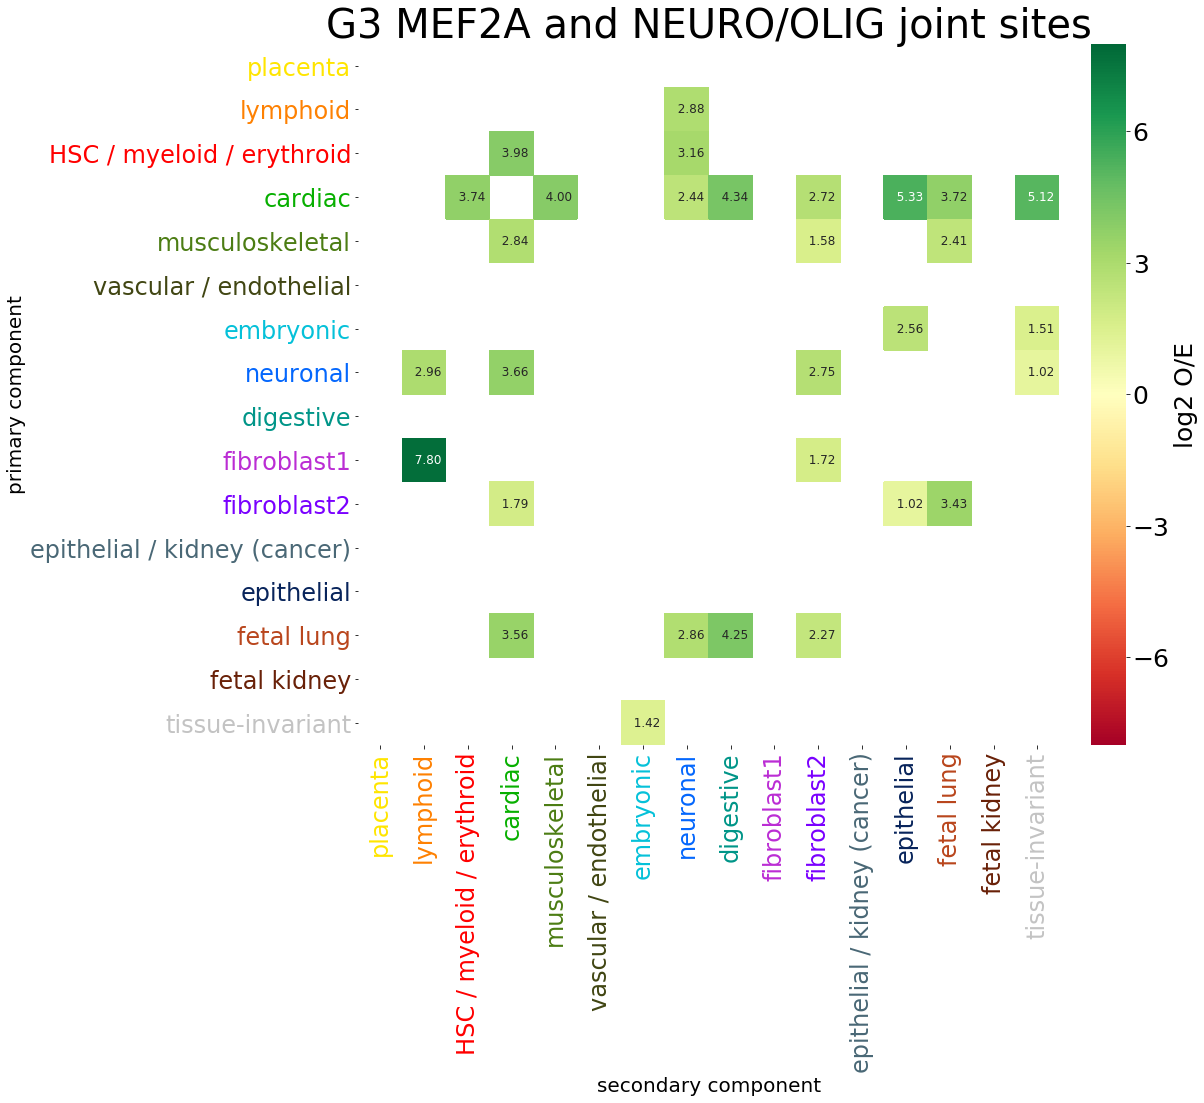

In [170]:
EM = return_expected_matrix(G3cut) 

joint_motif_G3_pvalues = []
joint_motif_G3 = return_expected_matrix(G3cut * motif_pair_cut) 
all_matrix = return_expected_matrix(G3cut)
for main_comp in joint_motif_G3.columns.values[WSO]:
    pvalrow = []
    for second_comp in joint_motif_G3.columns.values[WSO]:
        #print('main comp:', main_comp, 'second comp:',second_comp)
        YesYes = joint_motif_G3.loc[main_comp][second_comp]
        YesNo = joint_motif_G3.values.sum() - YesYes 
        NoYes = all_matrix.loc[main_comp][second_comp] - YesYes
        NoNo = all_matrix.values.sum() - YesNo - NoYes - YesYes
        my_p = fisher_exact([[YesYes, YesNo], [NoYes, NoNo]])
        #print(my_p)
        pvalrow.append(my_p[1])
    
    joint_motif_G3_pvalues.append(pvalrow)
joint_motif_G3_pvalues = np.array(joint_motif_G3_pvalues)

big_grid_plot(G3cut*motif_pair_cut,plt_title='G3 MEF2A and NEURO/OLIG joint sites',  logOOEmode = True, do_row_normalized_shading=False, ExpectedMatrix=EM, adjust_significance=True, do_extra_bargraphs=False, pmatrix = (joint_motif_G3_pvalues < 1e-5))

(16, 16)


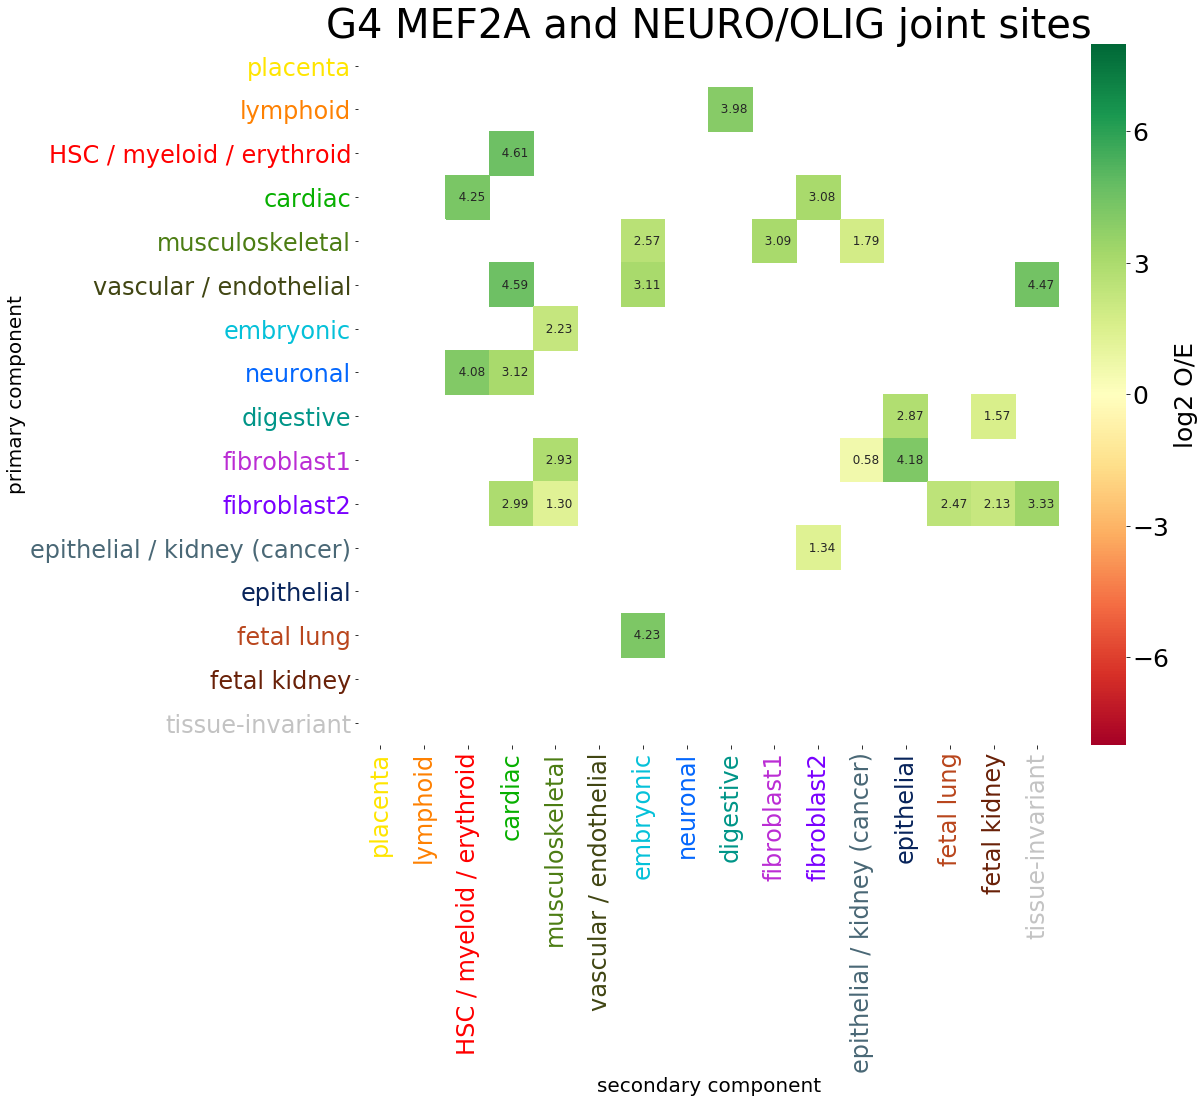

In [171]:
EM = return_expected_matrix(G4cut) 

joint_motif_G4_pvalues = []
joint_motif_G4 = return_expected_matrix(G4cut * motif_pair_cut) 
all_matrix = return_expected_matrix(G4cut)
for main_comp in joint_motif_G4.columns.values[WSO]:
    pvalrow = []
    for second_comp in joint_motif_G4.columns.values[WSO]:
        YesYes = joint_motif_G4.loc[main_comp][second_comp]
        YesNo = joint_motif_G4.values.sum() - YesYes 
        NoYes = all_matrix.loc[main_comp][second_comp] - YesYes
        NoNo = all_matrix.values.sum() - YesNo - NoYes - YesYes
        my_p = fisher_exact([[YesYes, YesNo], [NoYes, NoNo]])
        pvalrow.append(my_p[1])
    
    joint_motif_G4_pvalues.append(pvalrow)
joint_motif_G4_pvalues = np.array(joint_motif_G4_pvalues)

big_grid_plot(G4cut*motif_pair_cut,plt_title='G4 MEF2A and NEURO/OLIG joint sites',  logOOEmode = True, do_row_normalized_shading=False, ExpectedMatrix=EM, adjust_significance=True, do_extra_bargraphs=False, pmatrix = (joint_motif_G4_pvalues < 1e-5))

(16, 16)


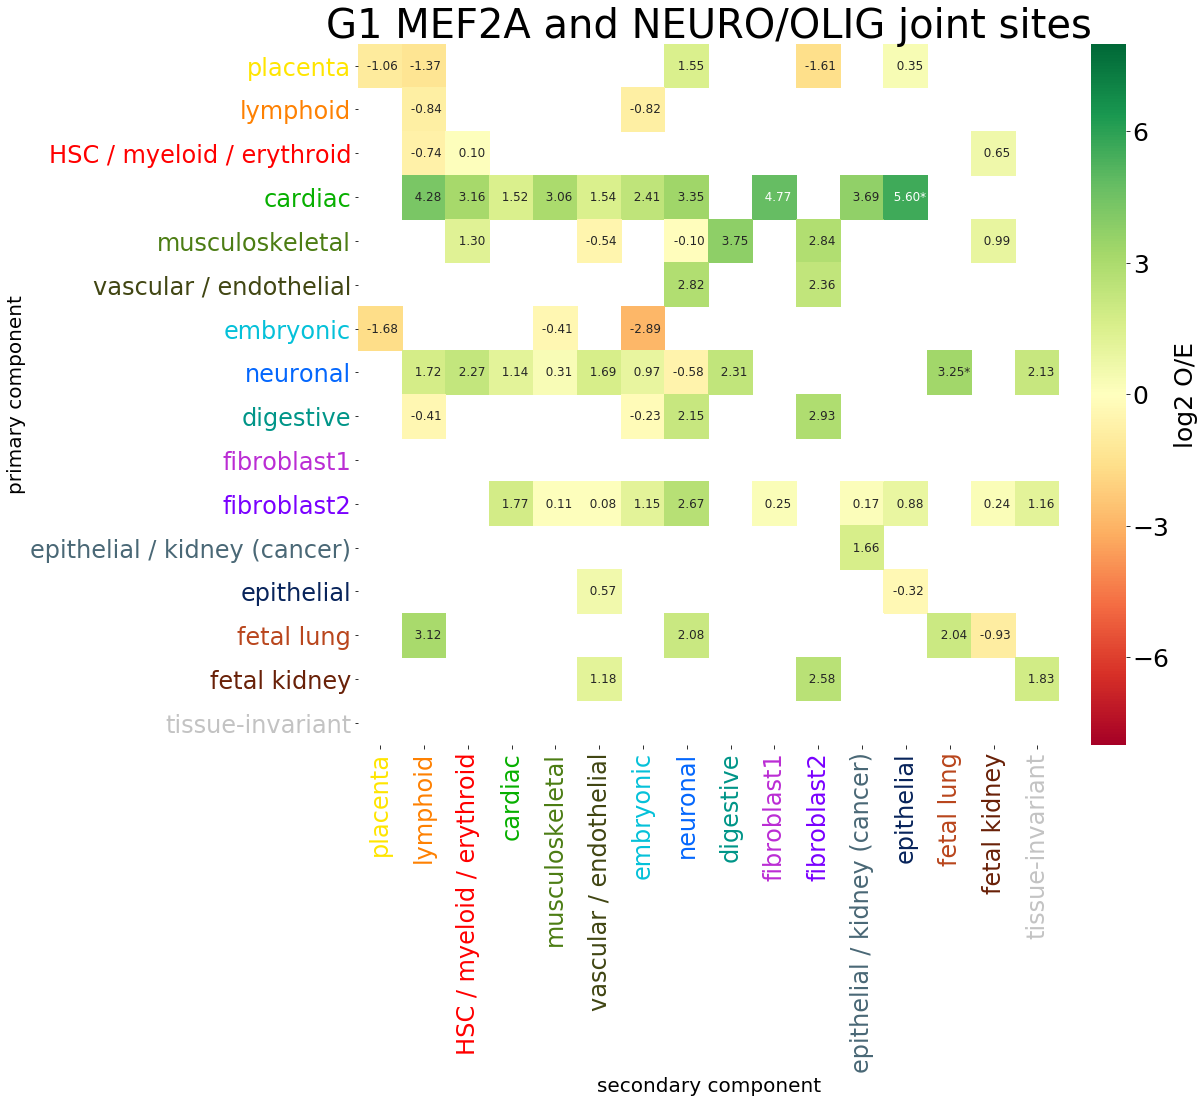

In [172]:
EM = return_expected_matrix(G1cut) 

joint_motif_G1_pvalues = []
joint_motif_G1 = return_expected_matrix(G1cut * motif_pair_cut) 
all_matrix = return_expected_matrix(G1cut)
for main_comp in joint_motif_G1.columns.values[WSO]:
    pvalrow = []
    for second_comp in joint_motif_G1.columns.values[WSO]:
        YesYes = joint_motif_G1.loc[main_comp][second_comp]
        YesNo = joint_motif_G1.values.sum() - YesYes 
        NoYes = all_matrix.loc[main_comp][second_comp] - YesYes
        NoNo = all_matrix.values.sum() - YesNo - NoYes - YesYes
        my_p = fisher_exact([[YesYes, YesNo], [NoYes, NoNo]])
        pvalrow.append(my_p[1])
    
    joint_motif_G1_pvalues.append(pvalrow)
joint_motif_G1_pvalues = np.array(joint_motif_G1_pvalues)

big_grid_plot(G1cut*motif_pair_cut,plt_title='G1 MEF2A and NEURO/OLIG joint sites',  logOOEmode = True, do_row_normalized_shading=False, ExpectedMatrix=EM, adjust_significance=True, do_extra_bargraphs=False, pmatrix = (joint_motif_G1_pvalues < 1e-5))

(16, 16)


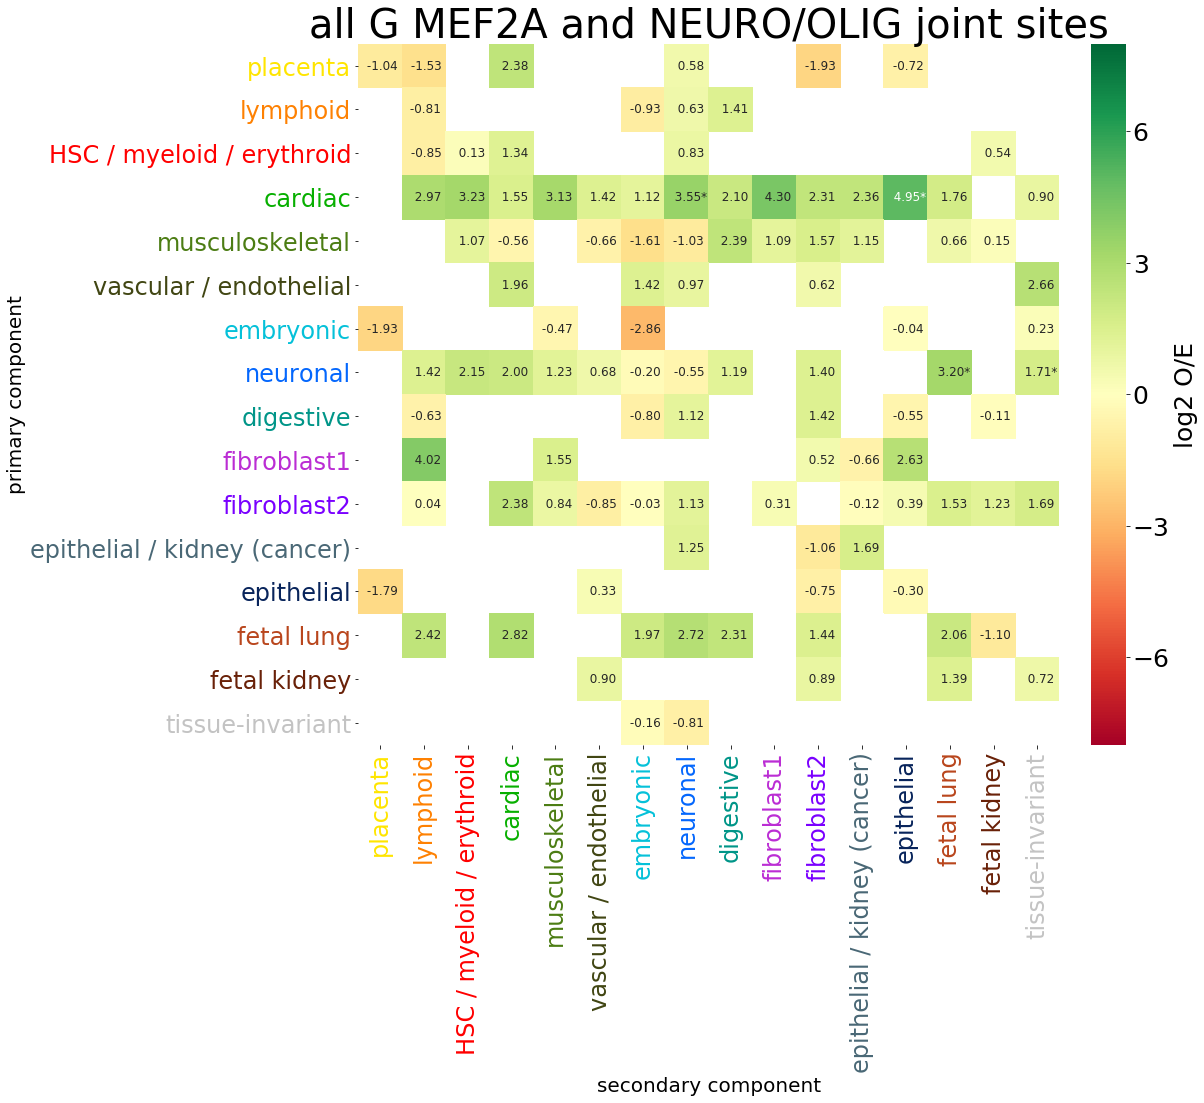

In [173]:
G5cut = maxcolor>-1
EM = return_expected_matrix(G5cut) 

joint_motif_G5_pvalues = []
joint_motif_G5 = return_expected_matrix(G5cut * motif_pair_cut) 
all_matrix = return_expected_matrix(G5cut)
for main_comp in joint_motif_G5.columns.values[WSO]:
    pvalrow = []
    for second_comp in joint_motif_G5.columns.values[WSO]:
        YesYes = joint_motif_G5.loc[main_comp][second_comp]
        YesNo = joint_motif_G5.values.sum() - YesYes 
        NoYes = all_matrix.loc[main_comp][second_comp] - YesYes
        NoNo = all_matrix.values.sum() - YesNo - NoYes - YesYes
        my_p = fisher_exact([[YesYes, YesNo], [NoYes, NoNo]])
        pvalrow.append(my_p[1])
    
    joint_motif_G5_pvalues.append(pvalrow)
joint_motif_G5_pvalues = np.array(joint_motif_G5_pvalues)

big_grid_plot(G5cut*motif_pair_cut,plt_title='all G MEF2A and NEURO/OLIG joint sites',  logOOEmode = True, do_row_normalized_shading=False, ExpectedMatrix=EM, adjust_significance=True, do_extra_bargraphs=False, pmatrix = (joint_motif_G5_pvalues < 1e-5))

In [177]:
str(datetime.date.today())

'2019-02-19'

In [178]:
motif2

'c65-NEURO/OLIG'

In [187]:
motif2.replace('/', '+')

'c65-NEURO+OLIG'